In [15]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
#warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.filterwarnings('ignore')  # To ignore all warnings that arise here to enhance clarity

import pickle

In [16]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

#############################################################################################
stop_words.extend(['from', 'also', 'would', 'say', 'percent', 'year', 'mention', 'make_sure', 'enough',
                   'yet', 'next', 'instead', 'perhaps', 'purely', 'thompson', 'matthew', 'charle', 'october',
                   'onetime',  'olivia', 'come', 'mike',  'martin',  'poorly', 'rainy_day',  'way', 'many',
                   'often', 'make', 'give',  'use',   'may', 'great', 'well', 'take', 'see', 'provide',
                   'time', 'example', 'good', 'feel', 'large', 'mark', 'include', 'sai', 'lalao', 'coffee', 'usaid',
                   'become', 'get', 'high', 'stay', 'day', 'cut', 'increase', 'even', 'number', 'organization',
                   'process', 'result', 'affiliate',  'offer', 'ict', 'white', 'jackson', 'susan', 'go', 'first', 'second'])

### Load LDA model and data

In [17]:
with open("savecorpus.pkl", "rb") as f:
    corpus = pickle.load(f)
with open("data_lemmatized.pkl", "rb") as f:
    data_lemmatized = pickle.load(f)
with open("id2word.pkl", "rb") as f:
    id2word = pickle.load(f)
lda_model =  gensim.models.LdaModel.load('lda.model')

In [18]:
#save pyLDAvis image
#pyLDAvis.save_html(vis,'lda.html')

## MALLET MODEL

In [19]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = '/users/jie/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word)

In [30]:
#save model
#ldamallet.save('mallet.model')
#load model
ldamallet =  gensim.models.LdaModel.load('mallet.model')

In [31]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('government', 0.0187651598676957),
   ('public', 0.015413450937155458),
   ('policy', 0.007607497243660419),
   ('state', 0.006857772877618523),
   ('datum', 0.0061962513781697905),
   ('foundation', 0.006063947078280044),
   ('university', 0.006019845644983462),
   ('city', 0.005997794928335171),
   ('support', 0.005733186328555678),
   ('political', 0.00557883131201764)]),
 (1,
  [('nonprofit', 0.05601436265709156),
   ('foundation', 0.03278843428139469),
   ('funder', 0.014532741188698857),
   ('donor', 0.011641311537371257),
   ('board', 0.01135783804214306),
   ('support', 0.011131059245960502),
   ('fund', 0.009940470566002078),
   ('mission', 0.009751488235849948),
   ('grant', 0.009675895303789095),
   ('grantee', 0.009619200604743456)]),
 (2,
  [('social', 0.03200342983960456),
   ('investment', 0.024160193685060023),
   ('business', 0.01649349339251488),
   ('investor', 0.015308181176233228),
   ('company', 0.014248966004236861),
   ('capital', 0.01334106728538283),


## Find optimal number of topic for MALLET

In [32]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [23]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=11, step=1)

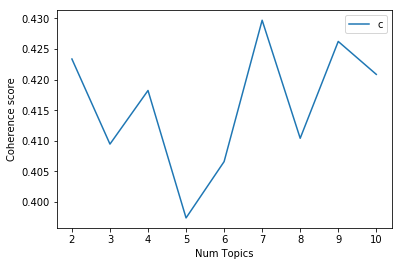

In [24]:
# Show graph
limit=11; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [25]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4234
Num Topics = 3  has Coherence Value of 0.4095
Num Topics = 4  has Coherence Value of 0.4182
Num Topics = 5  has Coherence Value of 0.3974
Num Topics = 6  has Coherence Value of 0.4066
Num Topics = 7  has Coherence Value of 0.4297
Num Topics = 8  has Coherence Value of 0.4104
Num Topics = 9  has Coherence Value of 0.4262
Num Topics = 10  has Coherence Value of 0.4208


In [26]:
# Select the model and print the topics
optimal_model = model_list[8]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.022*"poor" + 0.021*"woman" + 0.014*"people" + 0.012*"loan" + '
  '0.011*"poverty" + 0.011*"service" + 0.010*"client" + 0.008*"bank" + '
  '0.008*"microfinance" + 0.008*"economic"'),
 (1,
  '0.030*"social" + 0.020*"market" + 0.019*"investment" + 0.018*"business" + '
  '0.015*"company" + 0.015*"investor" + 0.013*"capital" + 0.011*"impact" + '
  '0.011*"create" + 0.010*"invest"'),
 (2,
  '0.015*"social" + 0.013*"change" + 0.009*"group" + 0.009*"public" + '
  '0.008*"political" + 0.008*"issue" + 0.008*"government" + 0.008*"support" + '
  '0.007*"policy" + 0.006*"member"'),
 (3,
  '0.035*"company" + 0.019*"business" + 0.014*"corporate" + '
  '0.011*"environmental" + 0.011*"corporation" + 0.011*"consumer" + '
  '0.010*"product" + 0.008*"global" + 0.008*"sustainability" + 0.007*"issue"'),
 (4,
  '0.022*"people" + 0.011*"work" + 0.008*"brand" + 0.006*"merger" + '
  '0.006*"director" + 0.005*"role" + 0.005*"founder" + 0.005*"board" + '
  '0.005*"thing" + 0.005*"idea"'),
 (5,
  '0.019*

In [33]:
#save optimal mallet model
#optimal_model.save('optimalmallet.model')
#load optimal mallet model
optimal_model = gensim.models.LdaModel.load('optimalmallet.model')

## Find the topic precentage of each document

In [36]:
lda_model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(optimal_model)

In [37]:
data=[]
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_lemmatized)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0            0             3.0              0.3826   
1            1             7.0              0.5330   
2            2             2.0              0.2818   
3            3             9.0              0.5680   
4            4             2.0              0.3323   
5            5             7.0              0.3468   
6            6             6.0              0.3490   
7            7             5.0              0.5632   
8            8             7.0              0.5759   
9            9             3.0              0.5739   

                                            Keywords  \
0  change, policy, issue, public, campaign, polit...   
1  change, innovation, work, social, create, impa...   
2  company, business, corporate, product, consume...   
3  foundation, funder, donor, datum, support, gra...   
4  company, business, corporate, product, consume...   
5  change, innovation, work, social, create, impa...   
6  social, investment, investor, fund, foundation...   
7  people, work, idea, evidence, find, research, ...   
8  change, innovation, work, social, create, impa...   
9  change, policy, issue, public, campaign, polit...   

                                                Text  
0  [big, deal, conservation, larry, linden, steve...  
1  [john_kania, kramer, winter, university, leade...  
2  [create, social, value, philip, auerswald, spr...  
3  [luck, draw, kevin, bolduc, phil_buchanan, ell...  
4  [partnership, learn, manage, tension, nonprofi...  
5  [reshape, social, paul, light, fall, leland_st...  
6  [social, case, definition, roger, sally_osberg...  
7  [spark, nonprofit, innovation, weird, manageme...  
8  [dawn, system, leadership, peter_senge, hamilt...  
9  [hide, cost, paradise, displace, create, wilde...

In [38]:
#save data to excel
#df_dominant_topic.to_excel('dominant_topic_MALLET.xlsx')

## Find the most representative document for each topic

In [39]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

Topic_Num  Topic_Perc_Contrib  \
0        0.0              0.6081   
1        1.0              0.6535   
2        2.0              0.6362   
3        3.0              0.5907   
4        4.0              0.5753   
5        5.0              0.6092   
6        6.0              0.6199   
7        7.0              0.6505   
8        8.0              0.5983   
9        9.0              0.6150   

                                            Keywords  \
0  poor, woman, health, service, people, poverty,...   
1  nonprofit, board, service, mission, management...   
2  company, business, corporate, product, consume...   
3  change, policy, issue, public, campaign, polit...   
4  network, social, government, service, communit...   
5  people, work, idea, evidence, find, research, ...   
6  social, investment, investor, fund, foundation...   
7  change, innovation, work, social, create, impa...   
8  school, student, teacher, education, child, pe...   
9  foundation, funder, donor, datum, support, gra...   

                                                Text  
0  [dial, development, david, lehr, fall, leland_...  
1  [feature, founder, succession, work, jari, tuo...  
2  [cultivate, green, consumer, sheila_bonini, je...  
3  [philanthropy, polarization, steven_tel, heath...  
4  [secret, scale, peter_murray, fall_uf, leland_...  
5  [rethink, self_esteem, nonprofit, stop, push, ...  
6  [private_equity, public, beth, sirull, fall, l...  
7  [feature, innovation, wrong, christian_seelo, ...  
8  [revolution, begin, teacher_prep, jonathan, sc...  
9  [calculated, impact, paul_brest, hal_harvey, k...

## Topic distribution across documents

In [40]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.head(10)

Dominant_Topic                                     Topic_Keywords  \
0             3.0  change, policy, issue, public, campaign, polit...   
1             7.0  change, innovation, work, social, create, impa...   
2             2.0  company, business, corporate, product, consume...   
3             9.0  foundation, funder, donor, datum, support, gra...   
4             2.0  company, business, corporate, product, consume...   
5             7.0  change, innovation, work, social, create, impa...   
6             6.0  social, investment, investor, fund, foundation...   
7             5.0  people, work, idea, evidence, find, research, ...   
8             7.0  change, innovation, work, social, create, impa...   
9             3.0  change, policy, issue, public, campaign, polit...   

   Num_Documents  Perc_Documents  
0           23.0          0.0987  
1           23.0          0.0987  
2           30.0          0.1288  
3           21.0          0.0901  
4           21.0          0.0901  
5           13.0          0.0558  
6           25.0          0.1073  
7           42.0          0.1803  
8           12.0          0.0515  
9           23.0          0.0987

In [ ]:
# Visualize the topics
lda_model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(optimal_model)

pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

In [ ]:
#save pyLDAvis image
pyLDAvis.save_html(vis,'MALLETvis.html')

## WordCloud

In [43]:
# Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors


x, y = np.ogrid[:300, :300]
mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)

# more colors: 'mcolors.XKCD_COLORS'
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                 # width=3000,
                  #height=2000,
                  max_words=500,
                  mask=mask,
                  colormap='tab15',
                  max_font_size=16,
                  min_font_size=3,
                  scale=2,
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(num_words=30, formatted=False)
# print(topics)

fig, axes = plt.subplots(5, 2, figsize=(20, 20), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [44]:
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color=None,
        stopwords=stop_words,
        max_words=300,
        max_font_size=30,
        scale=3,
        random_state=1,
        prefer_horizontal=1.0,
        mode='RGBA',
        mask=mask,
        min_font_size=3,
        #width=100000,
        #height=100000
    ).generate_from_frequencies(data)

    fig = plt.figure(1, figsize=(20, 20), dpi=300)
    
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    #plt.savefig('wwww.png')
    plt.show()
    

topics = lda_model.show_topics(num_words=2000, formatted=False)
topic_words0 = dict(topics[0][1])
topic_words1 = dict(topics[1][1])
topic_words2 = dict(topics[2][1])
topic_words3 = dict(topics[3][1])
topic_words4 = dict(topics[4][1])
topic_words5 = dict(topics[5][1])
topic_words6 = dict(topics[6][1])
topic_words7 = dict(topics[7][1])
topic_words8 = dict(topics[8][1])
topic_words9 = dict(topics[9][1])



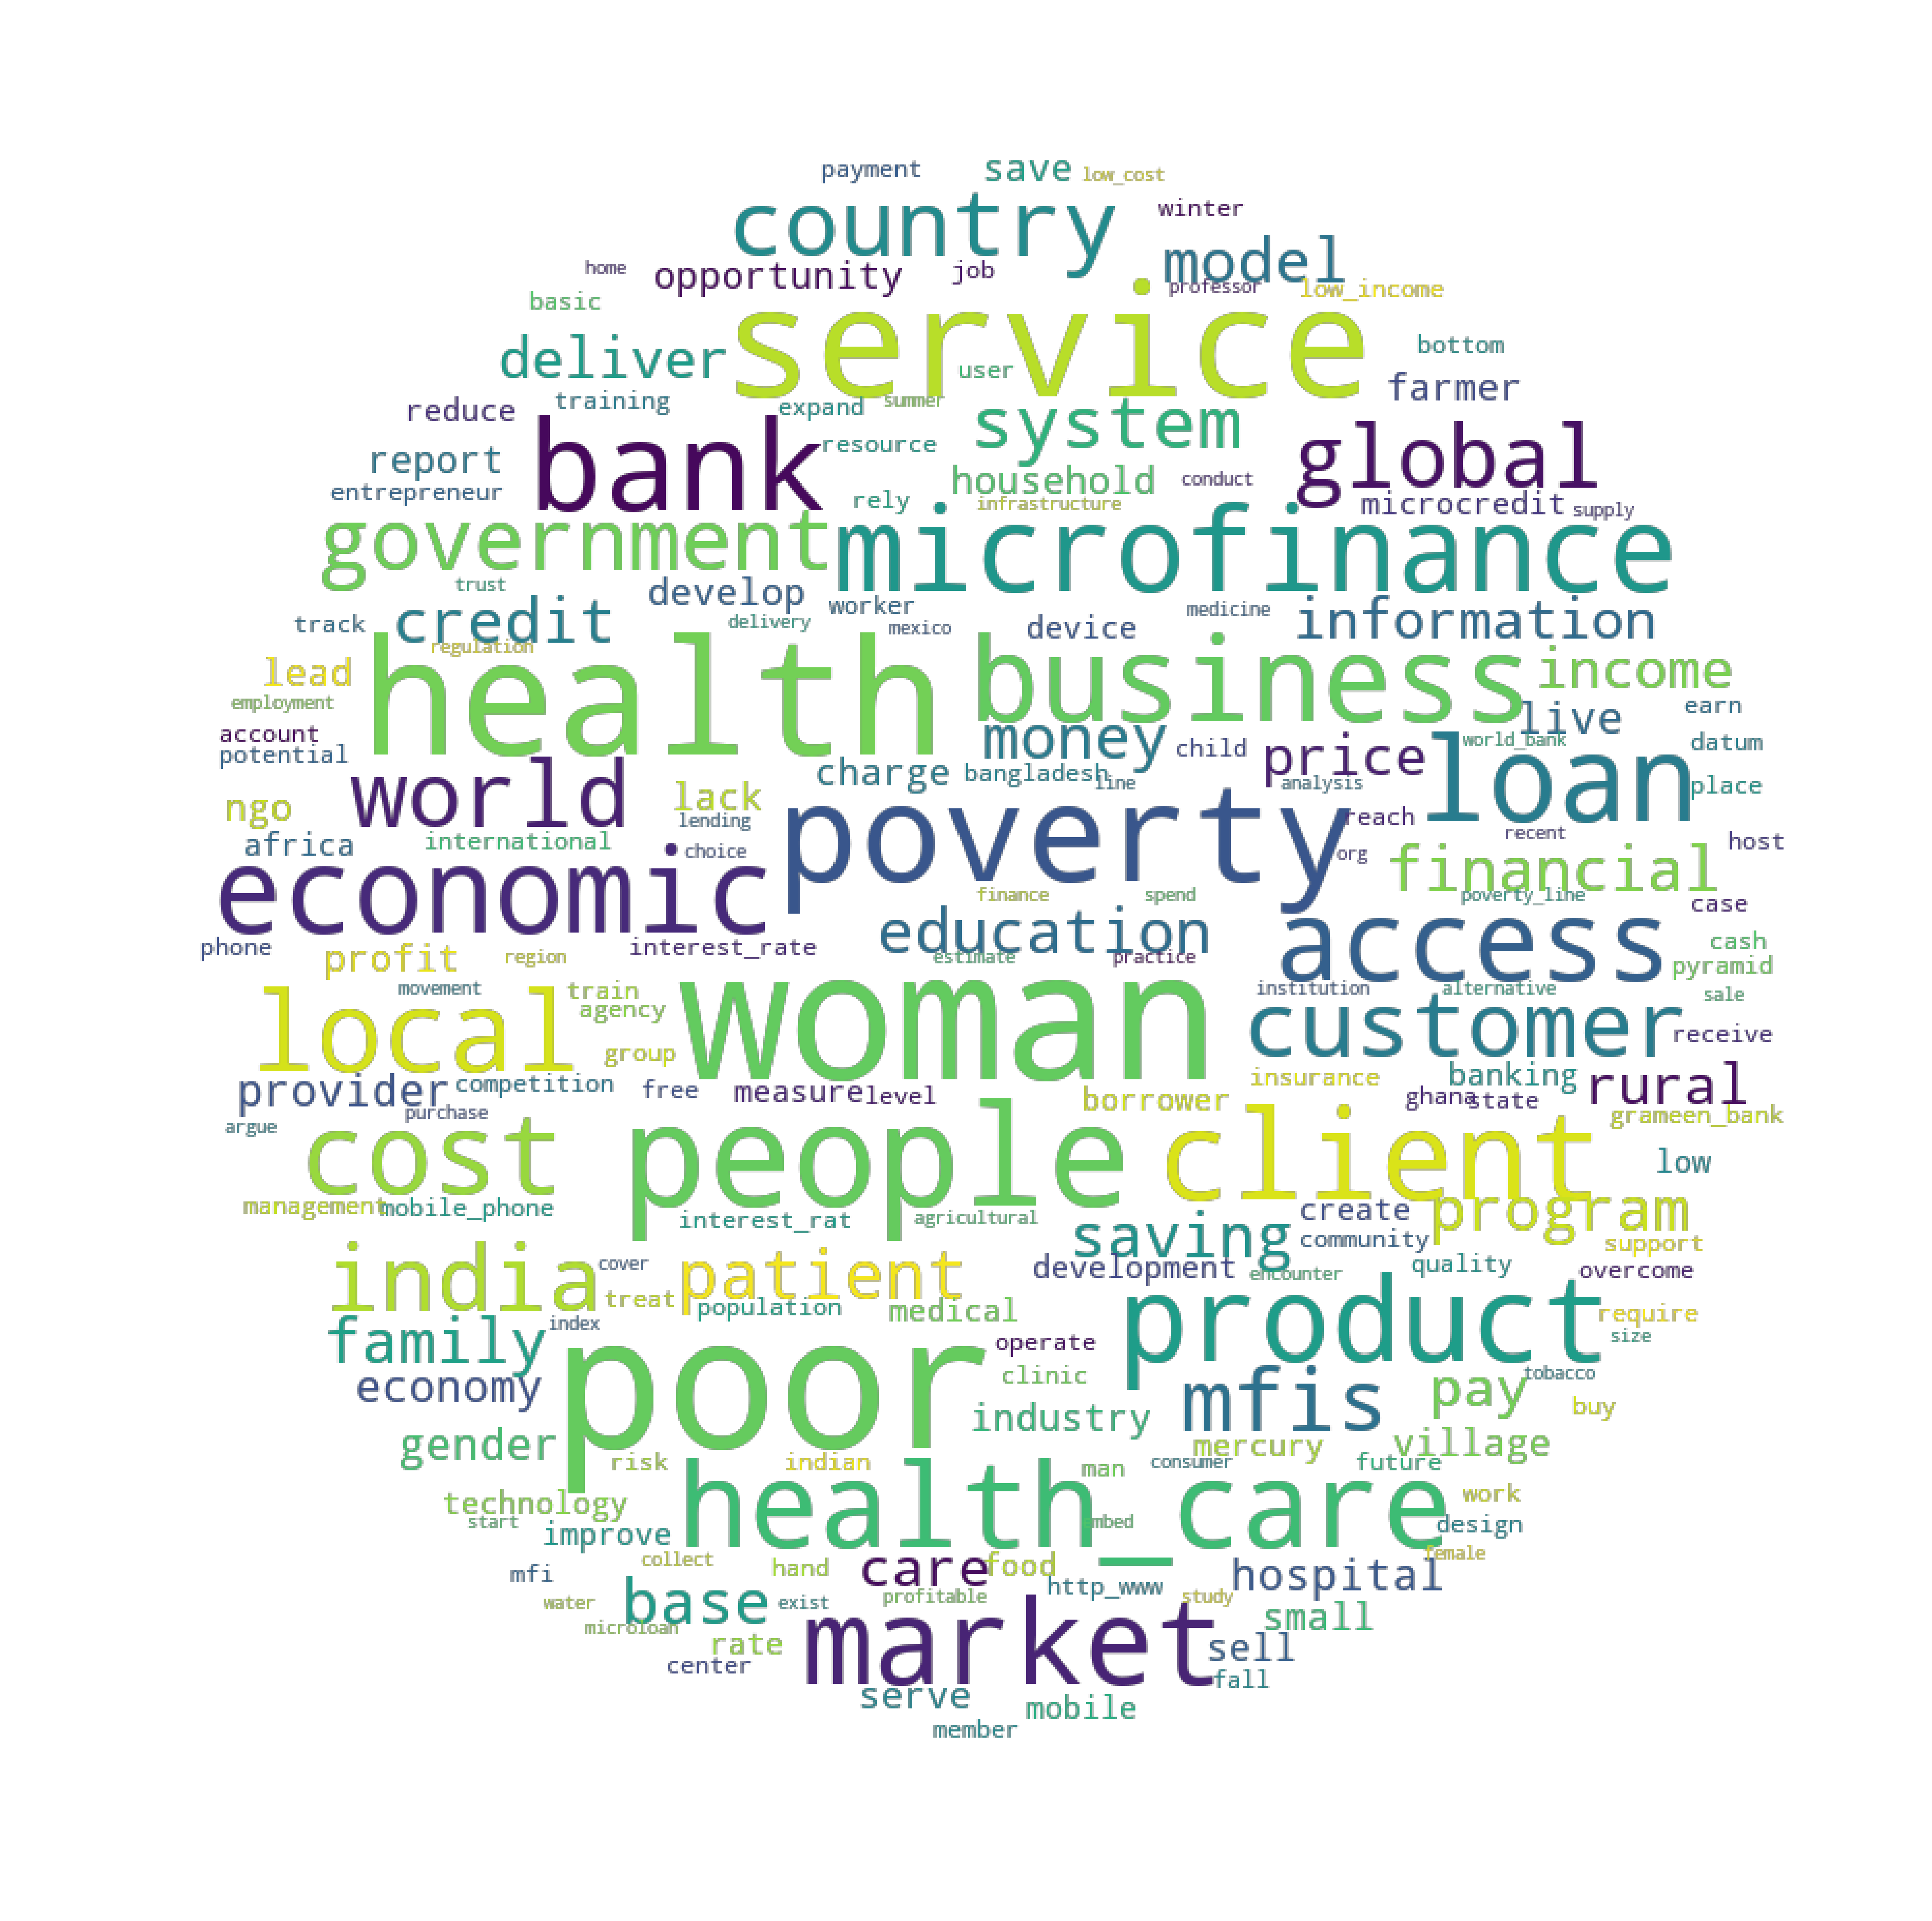

In [45]:
show_wordcloud(topic_words0)

In [46]:
show_wordcloud(topic_words1)

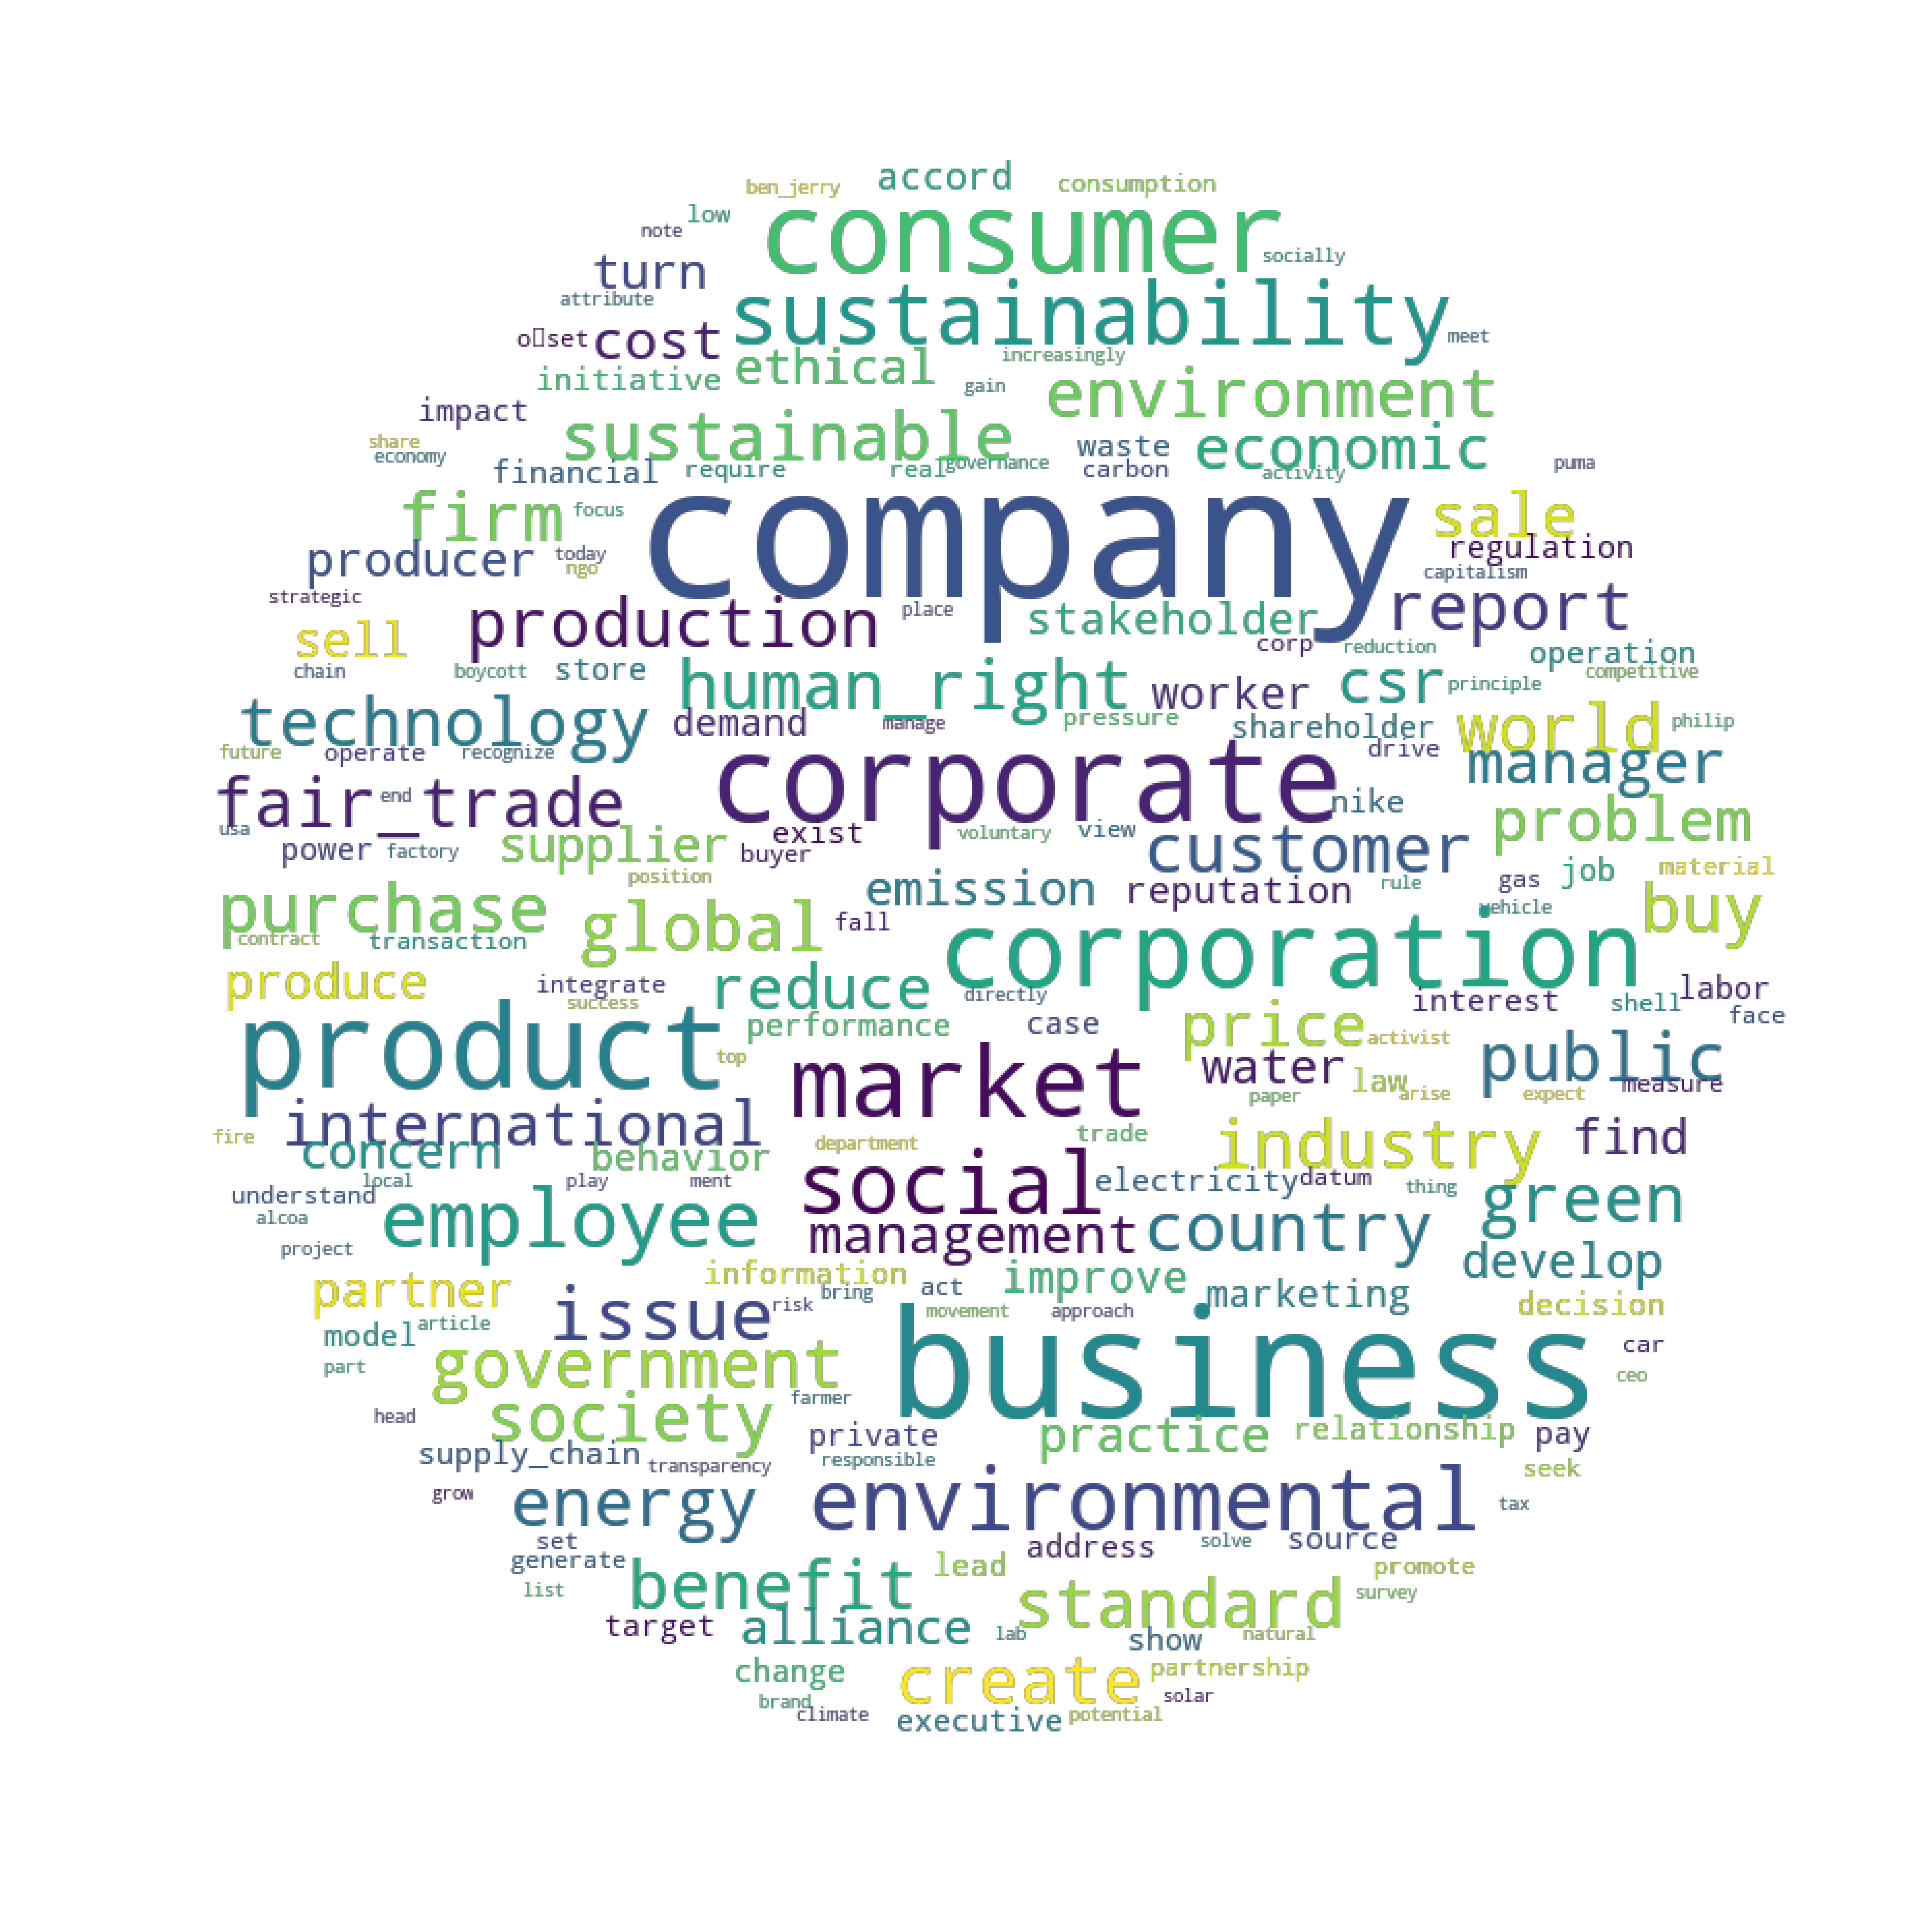

In [47]:
show_wordcloud(topic_words2)

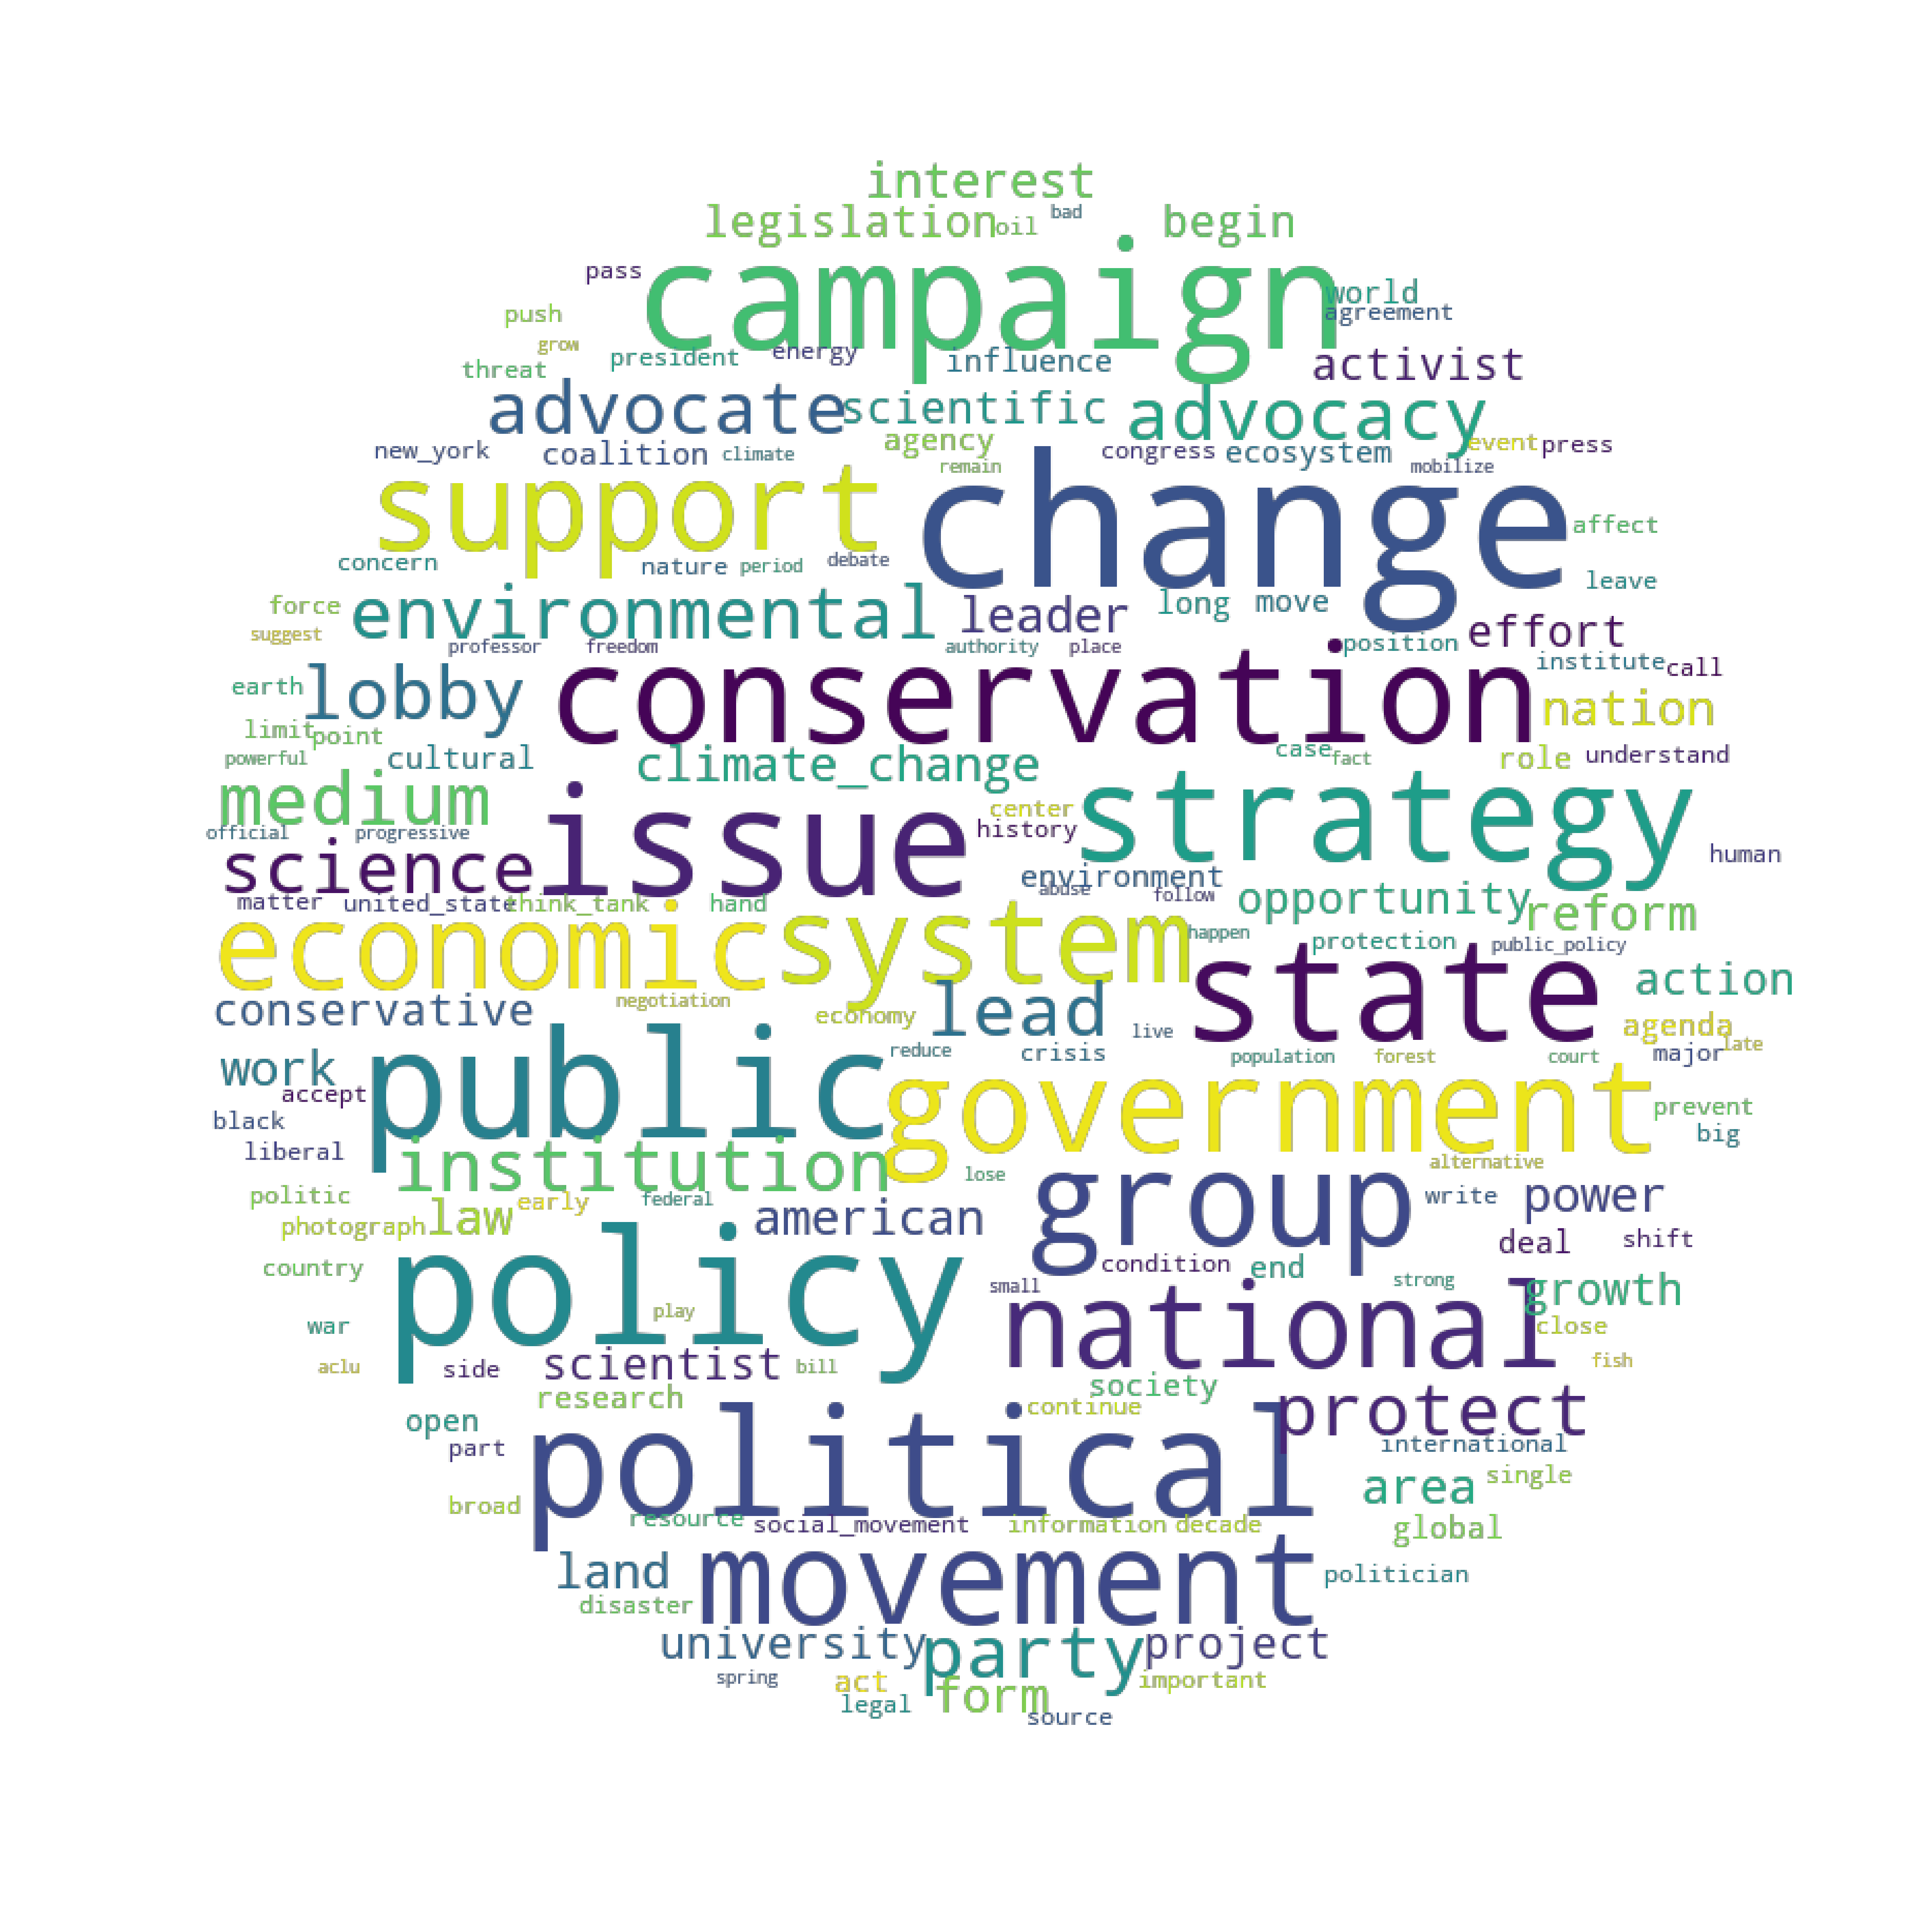

In [48]:
show_wordcloud(topic_words3)

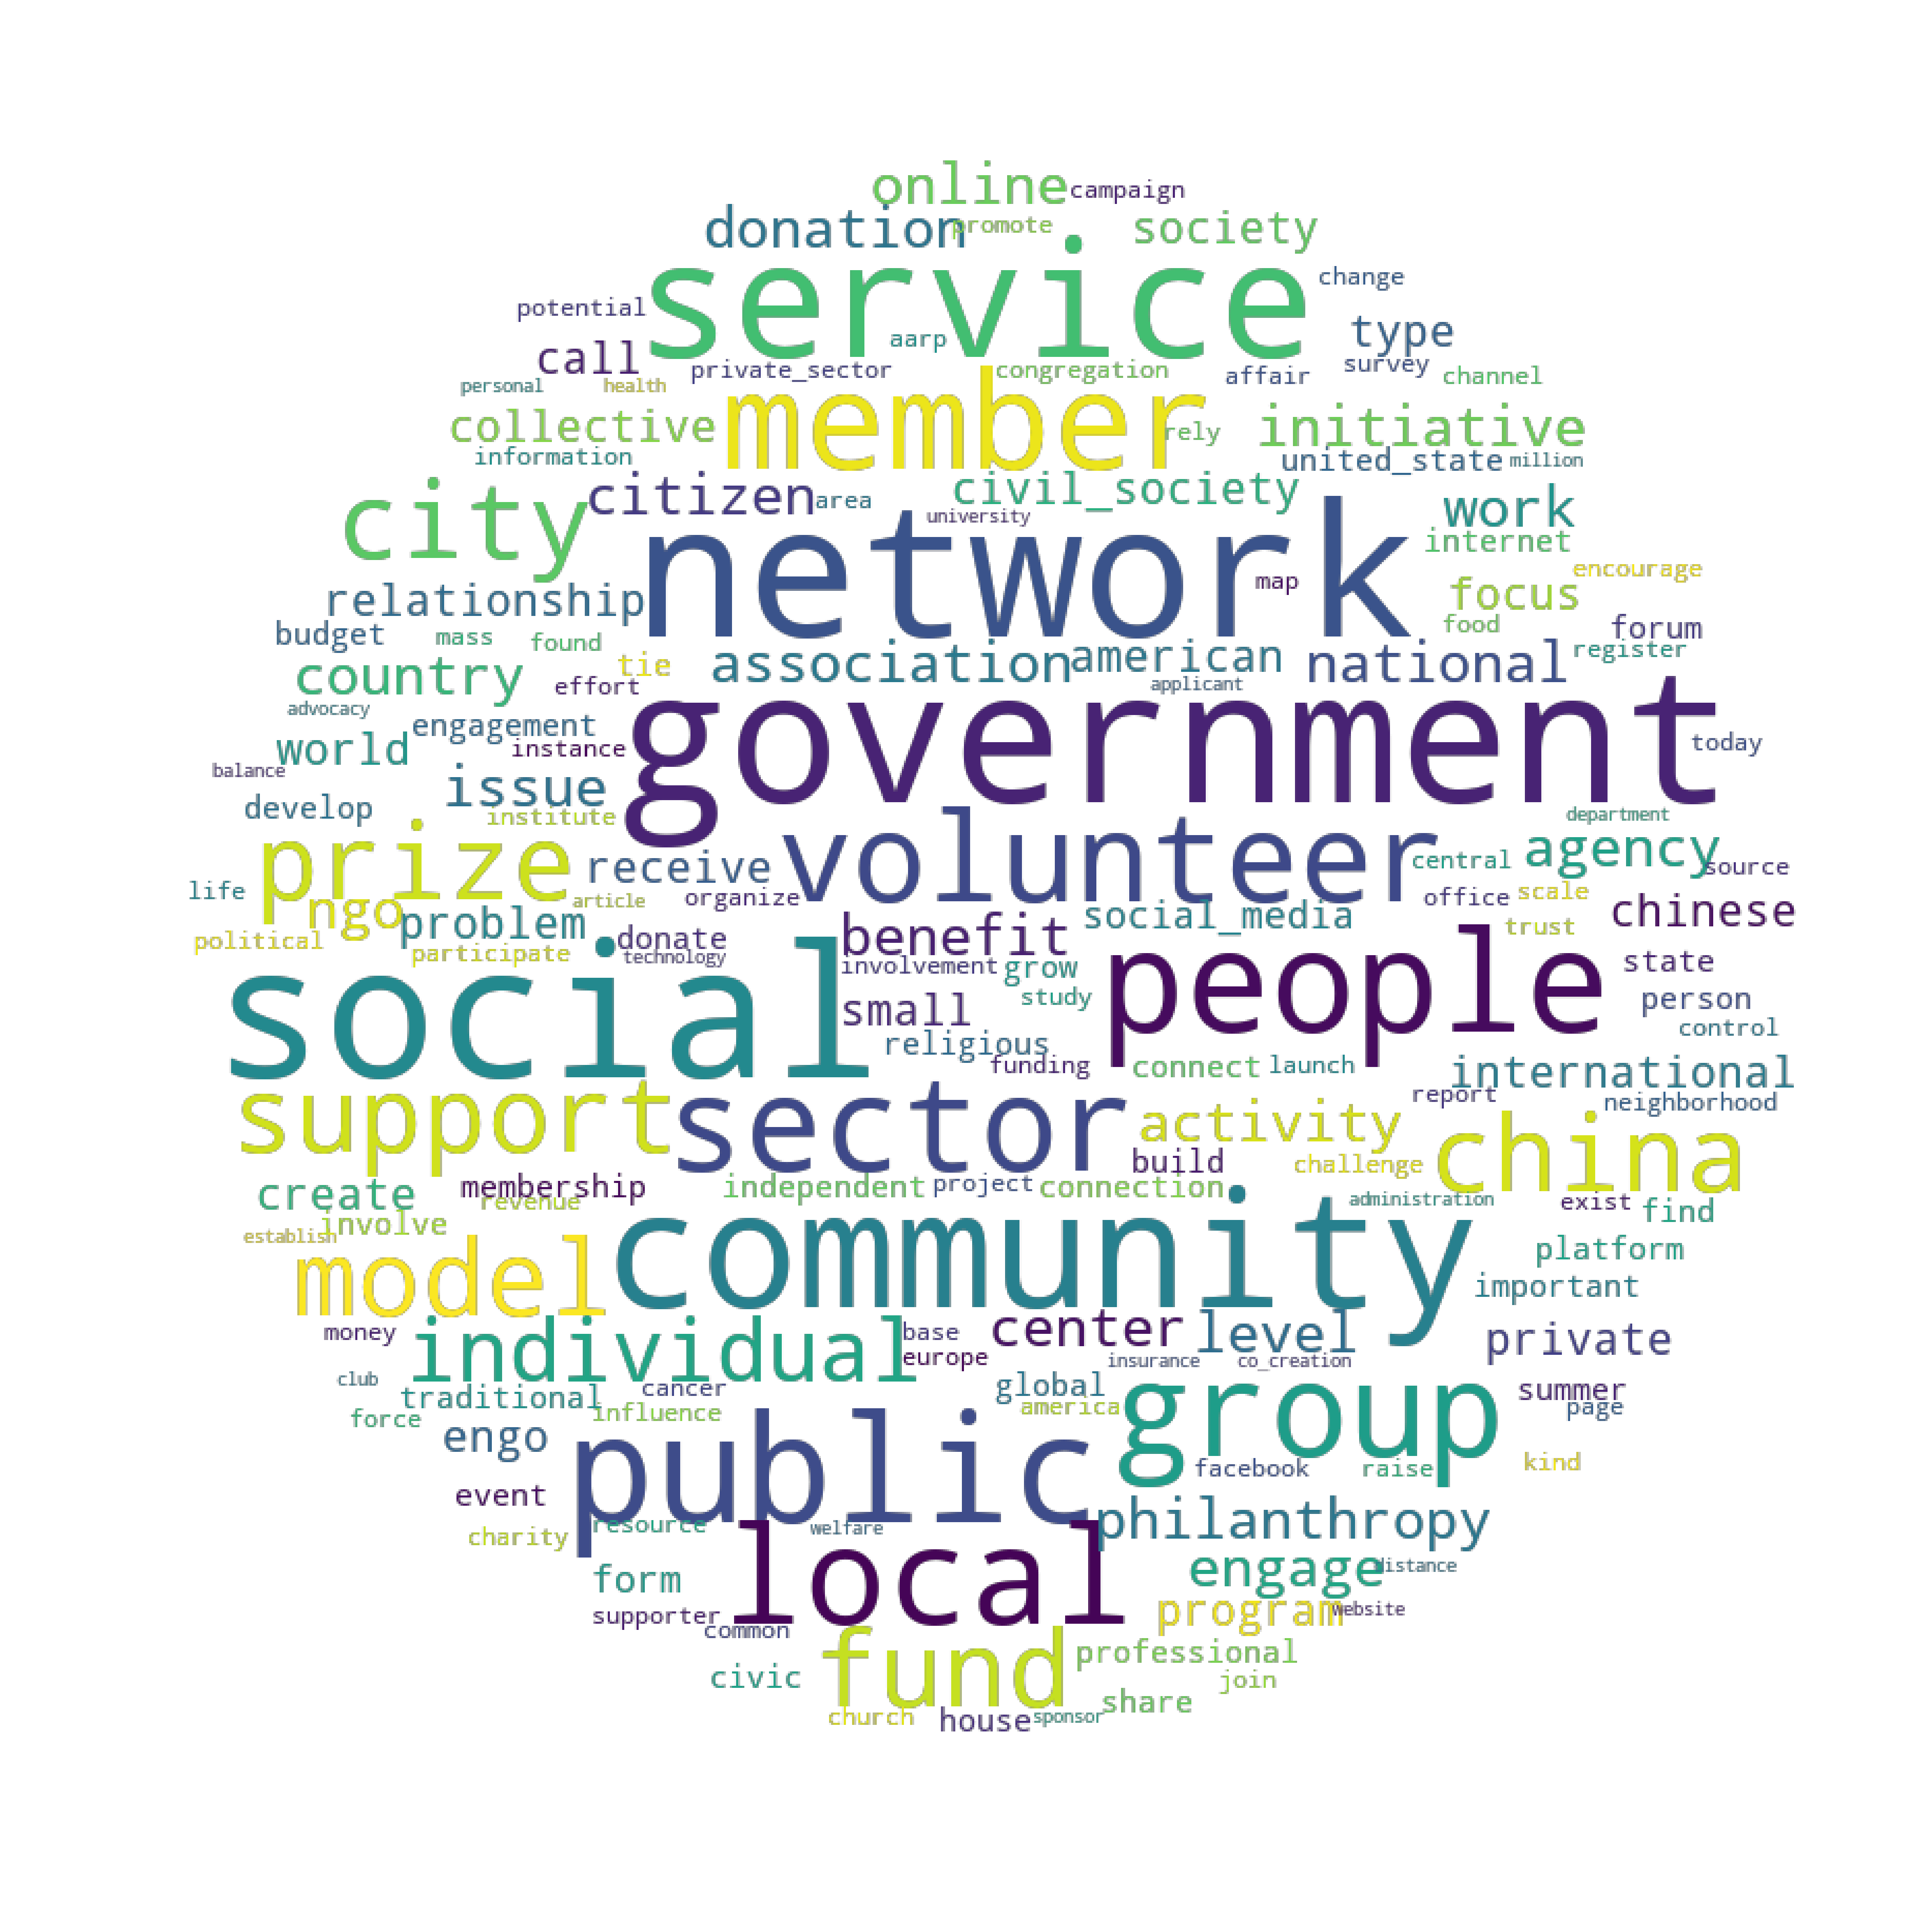

In [49]:
show_wordcloud(topic_words4)

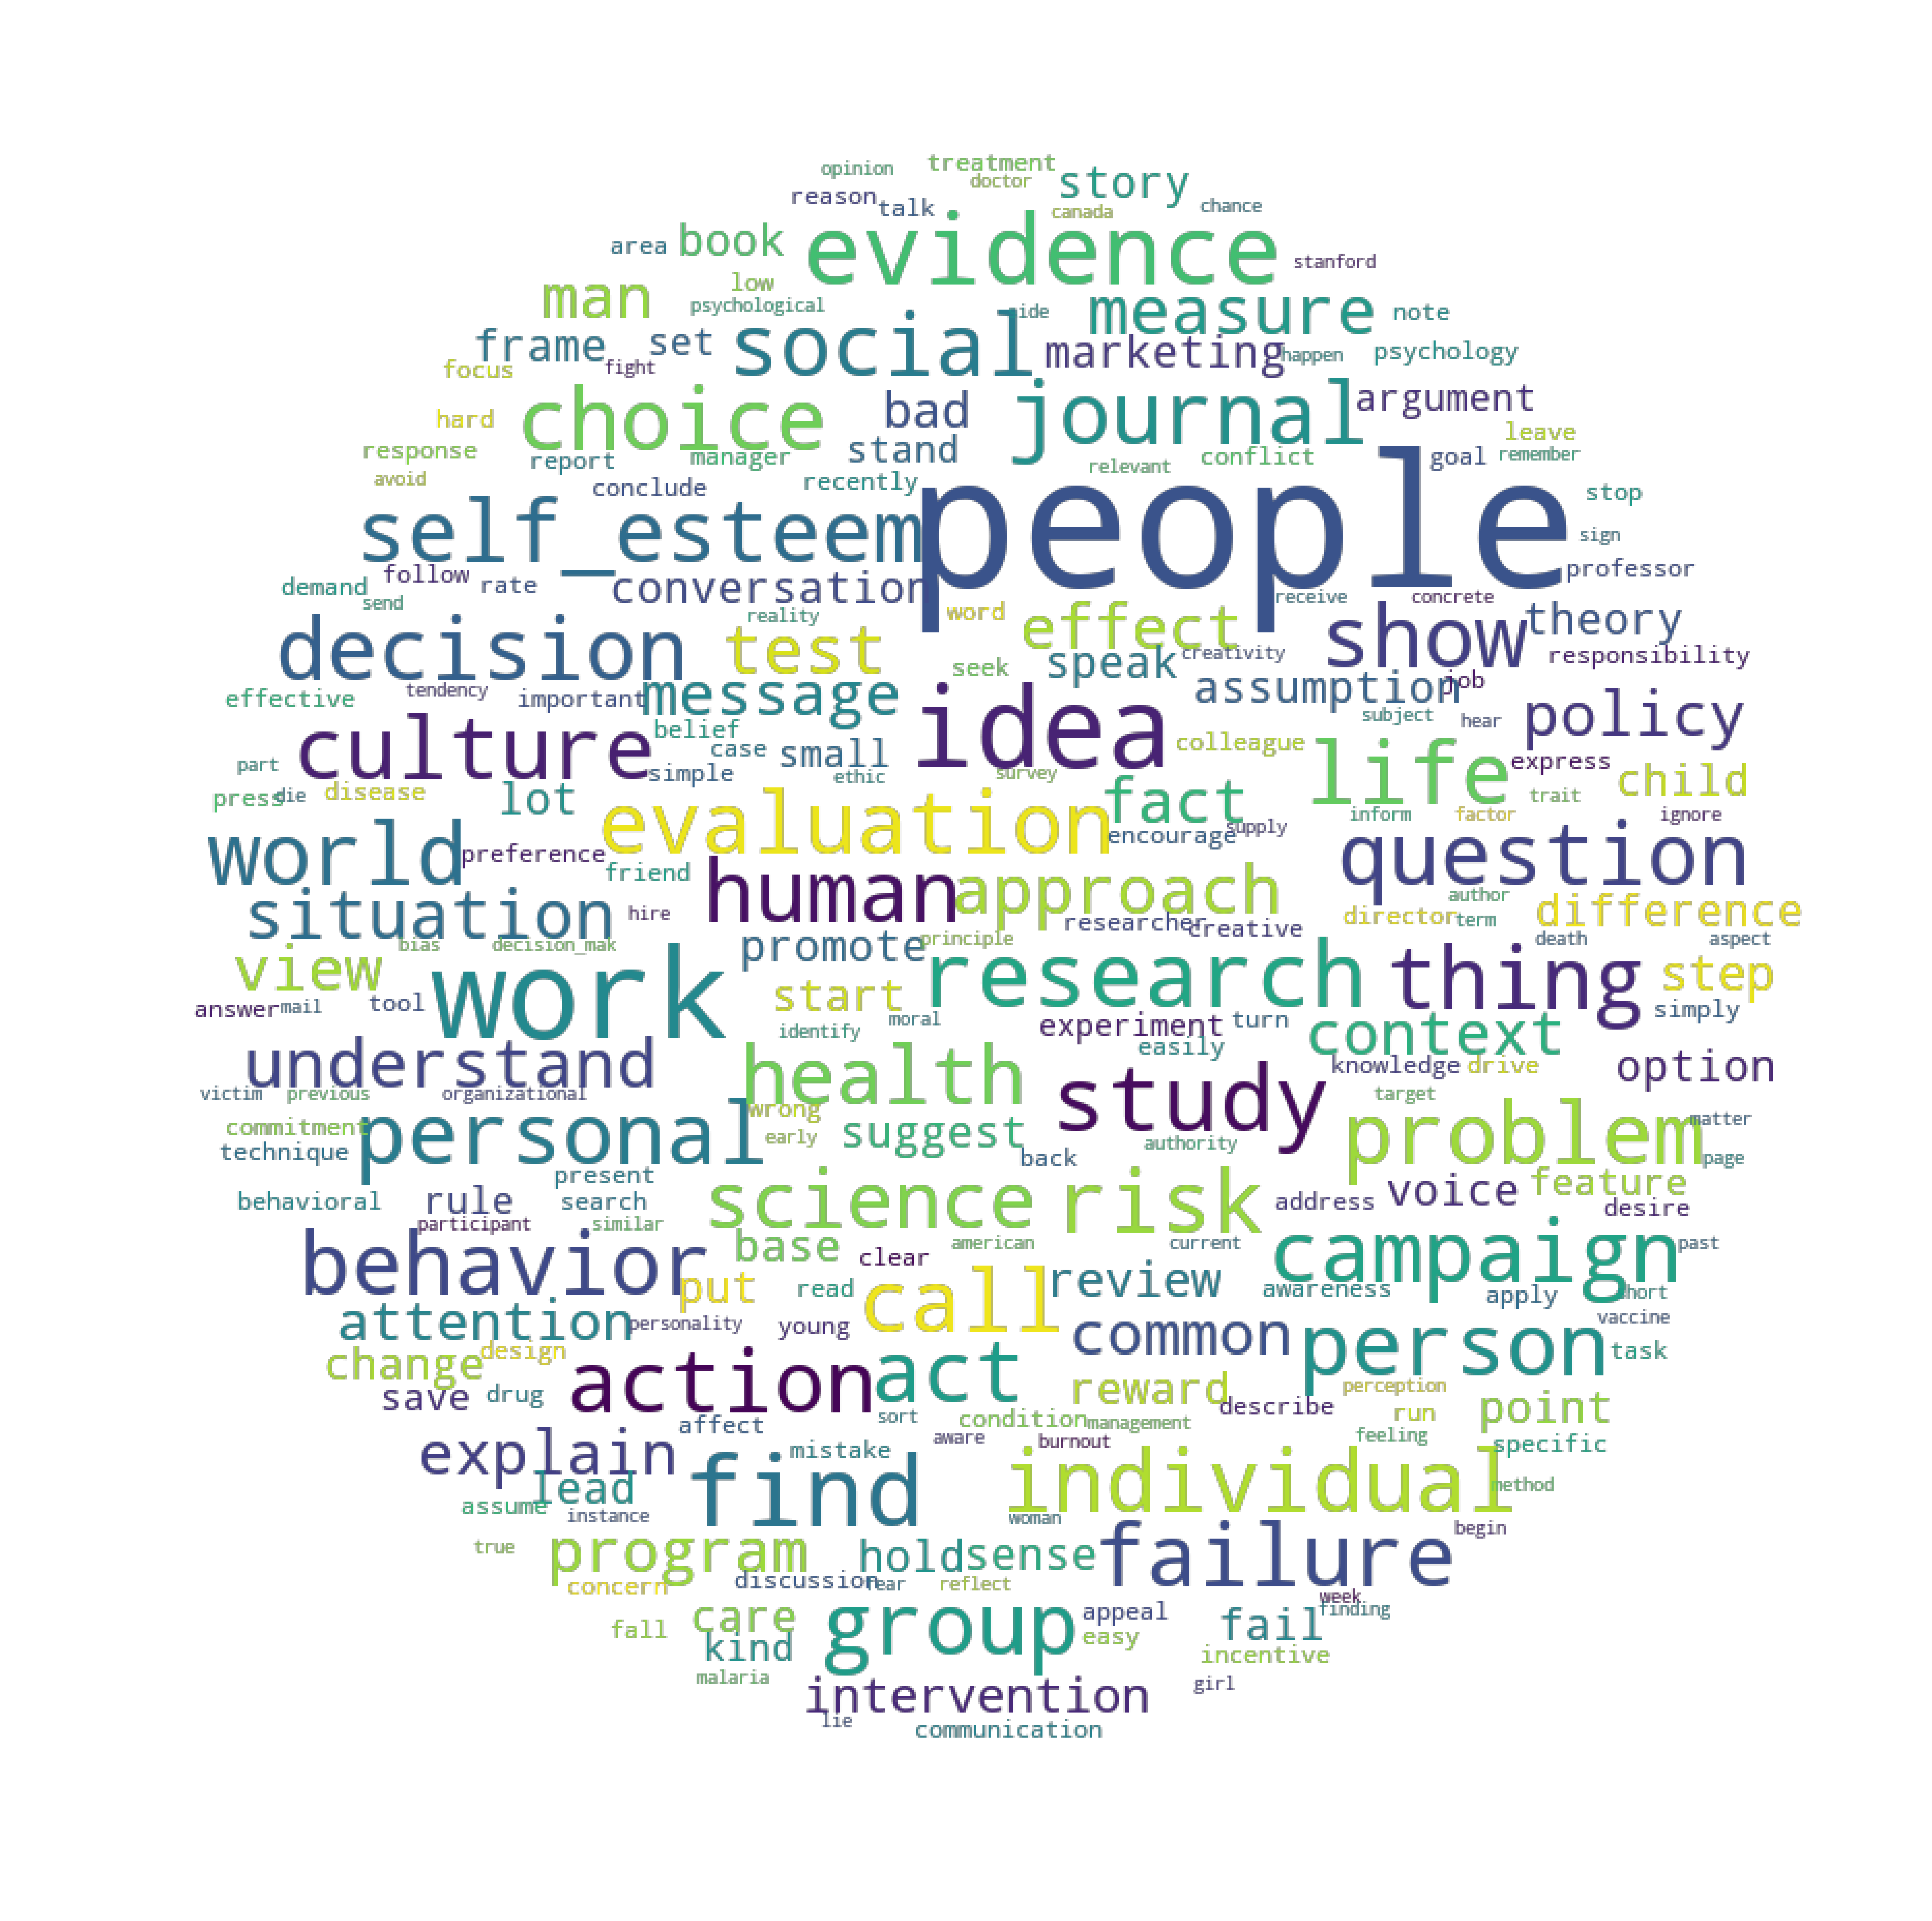

In [50]:
show_wordcloud(topic_words5)

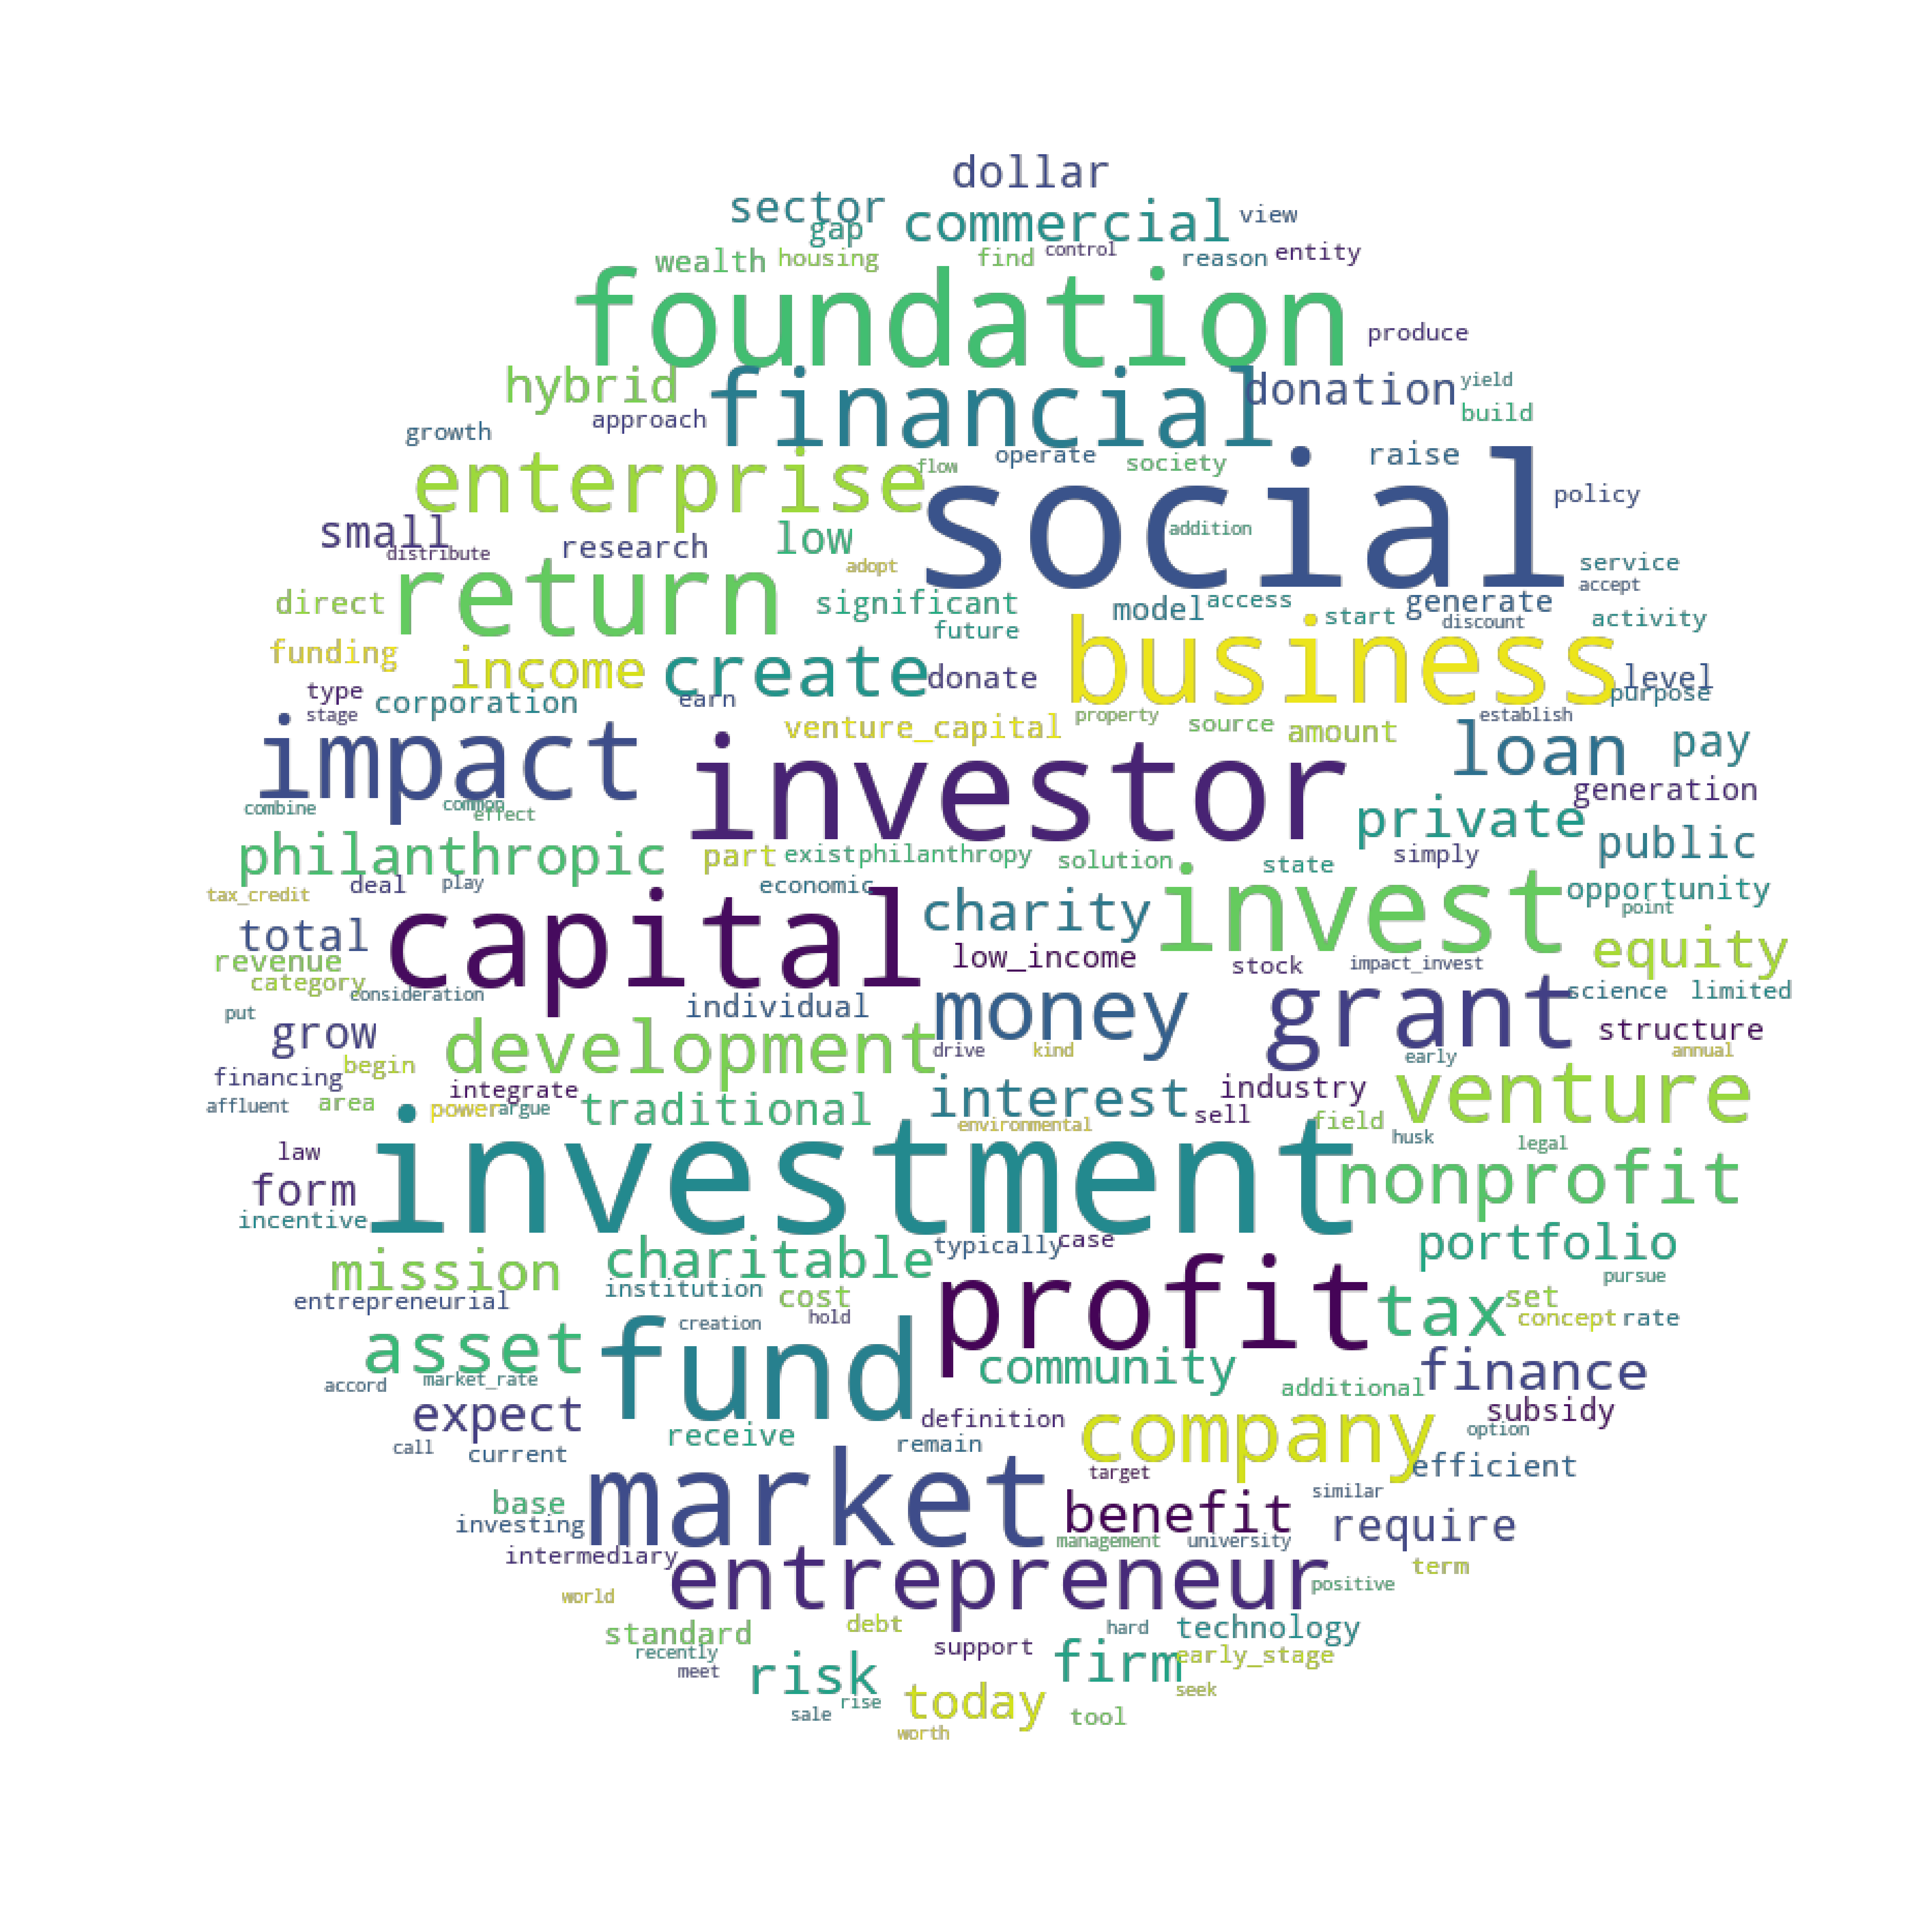

In [51]:
show_wordcloud(topic_words6)

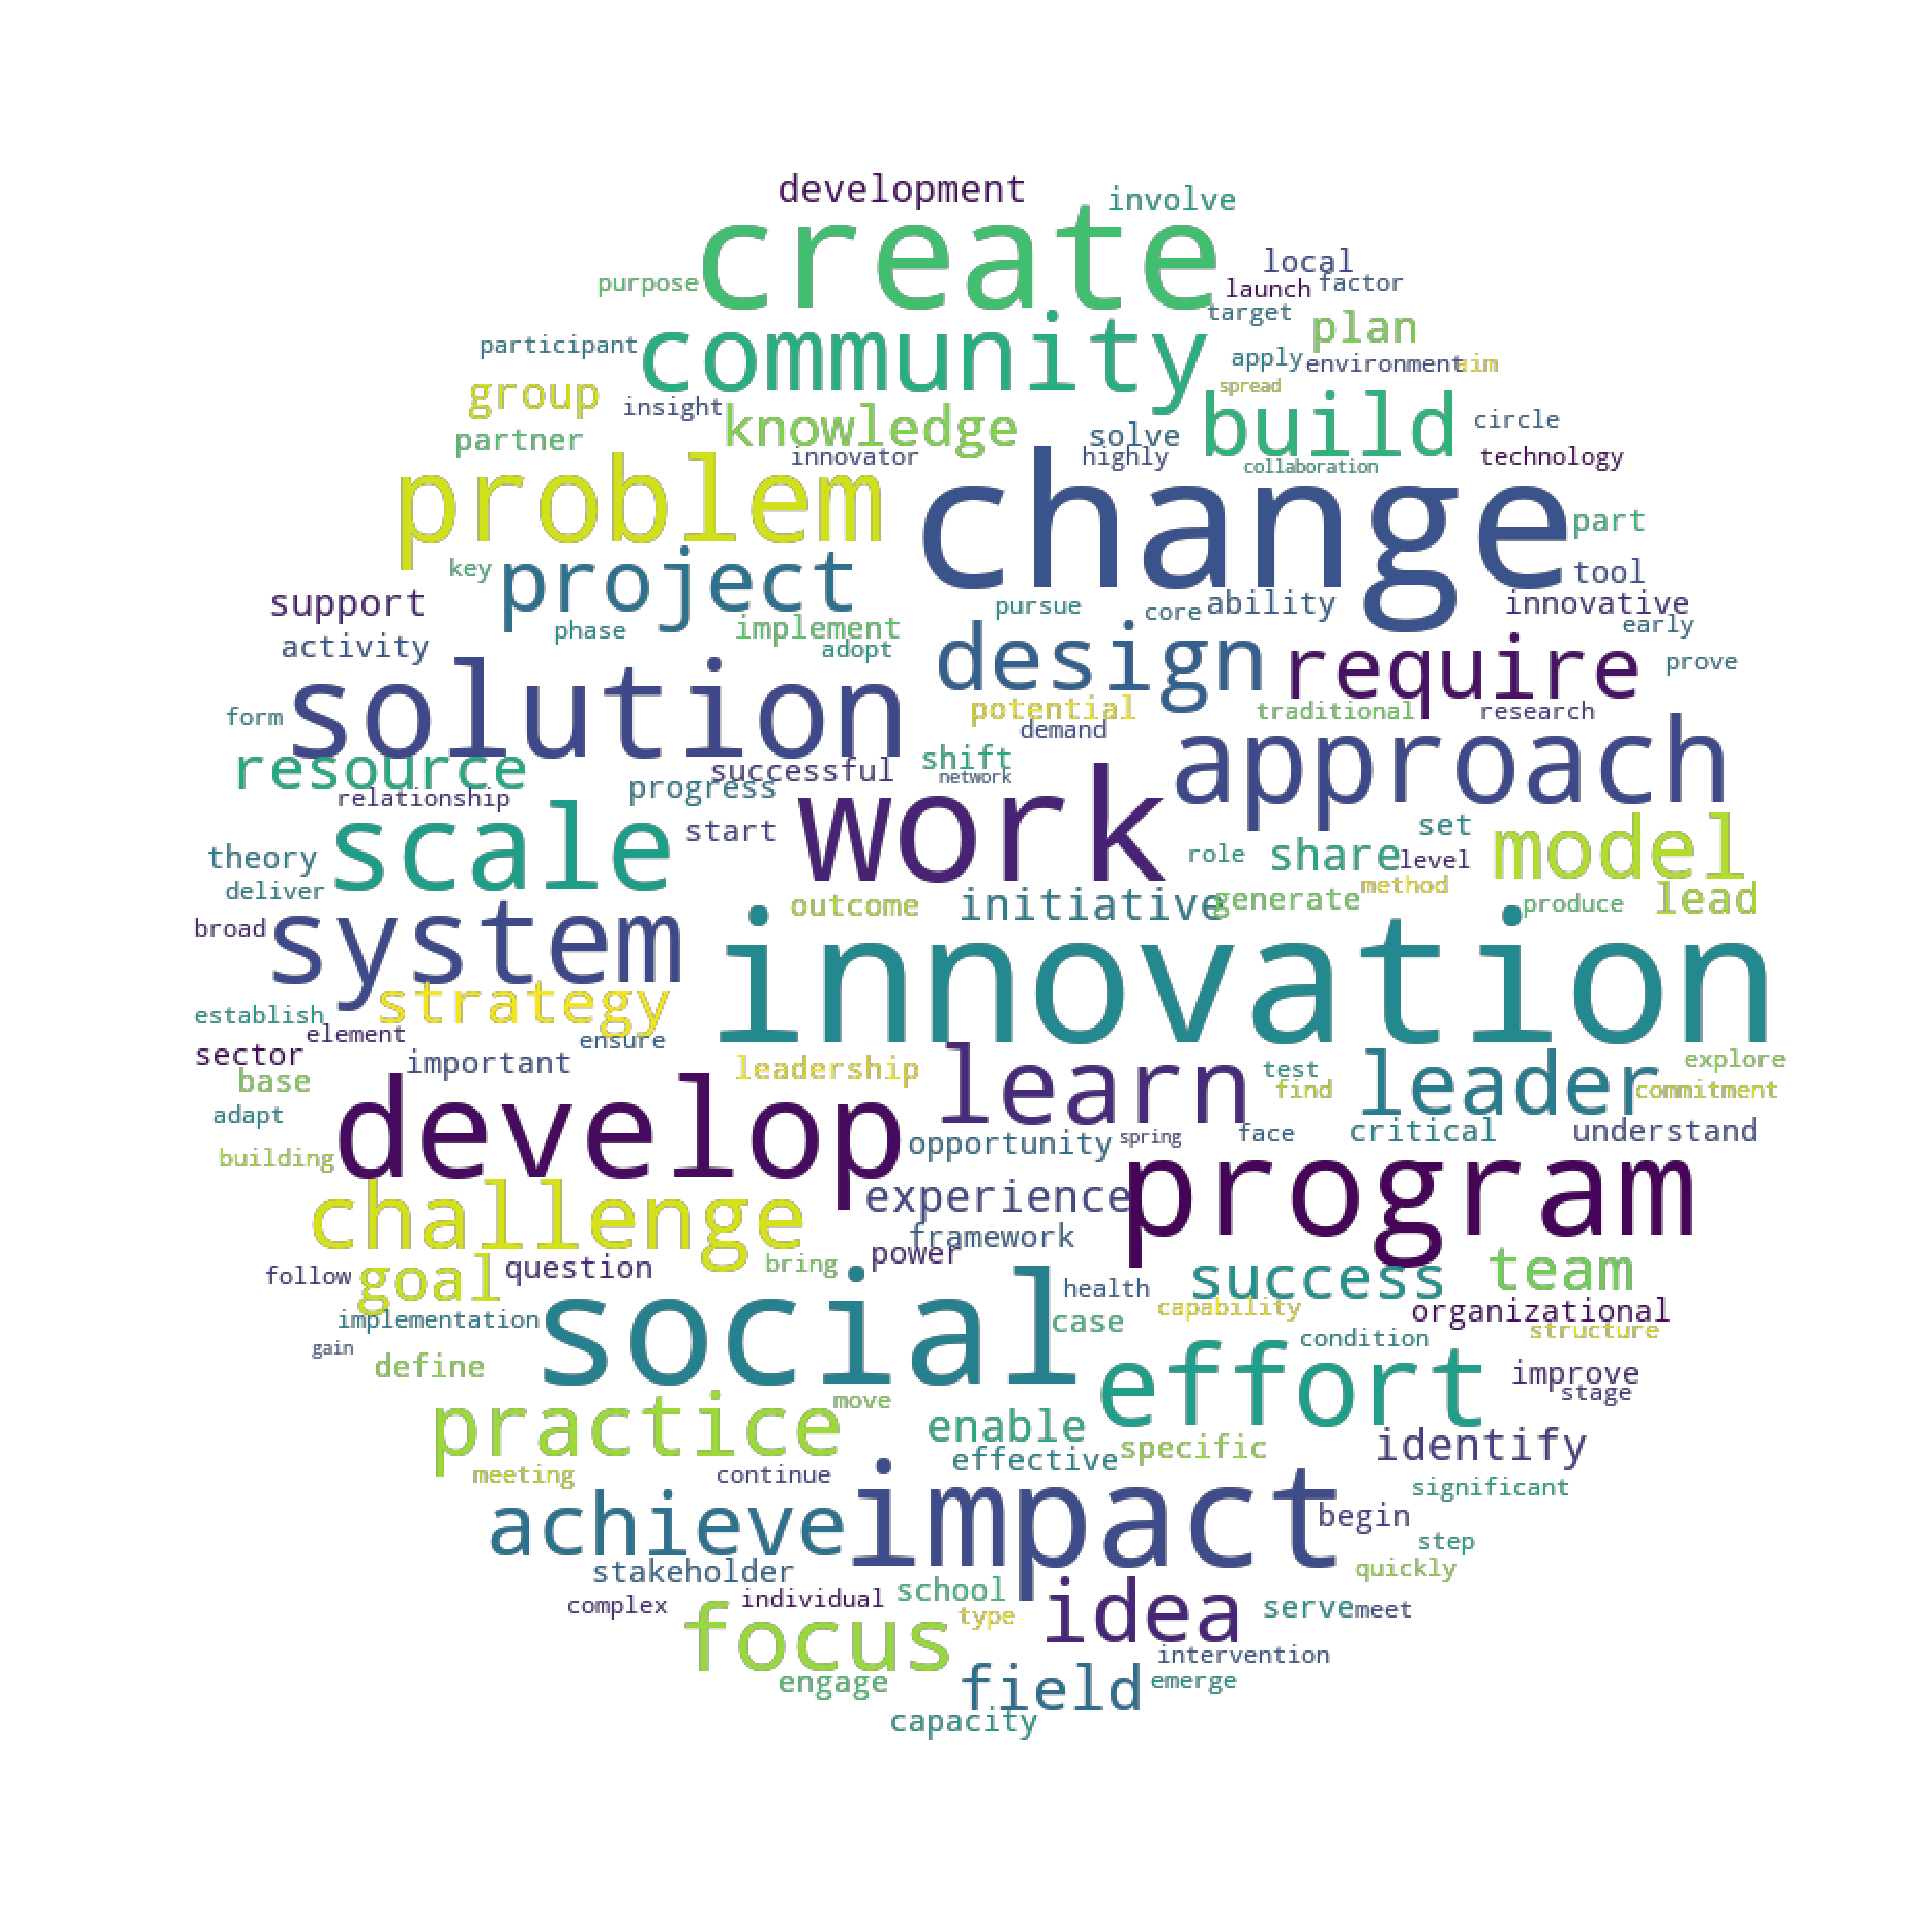

In [52]:
show_wordcloud(topic_words7)

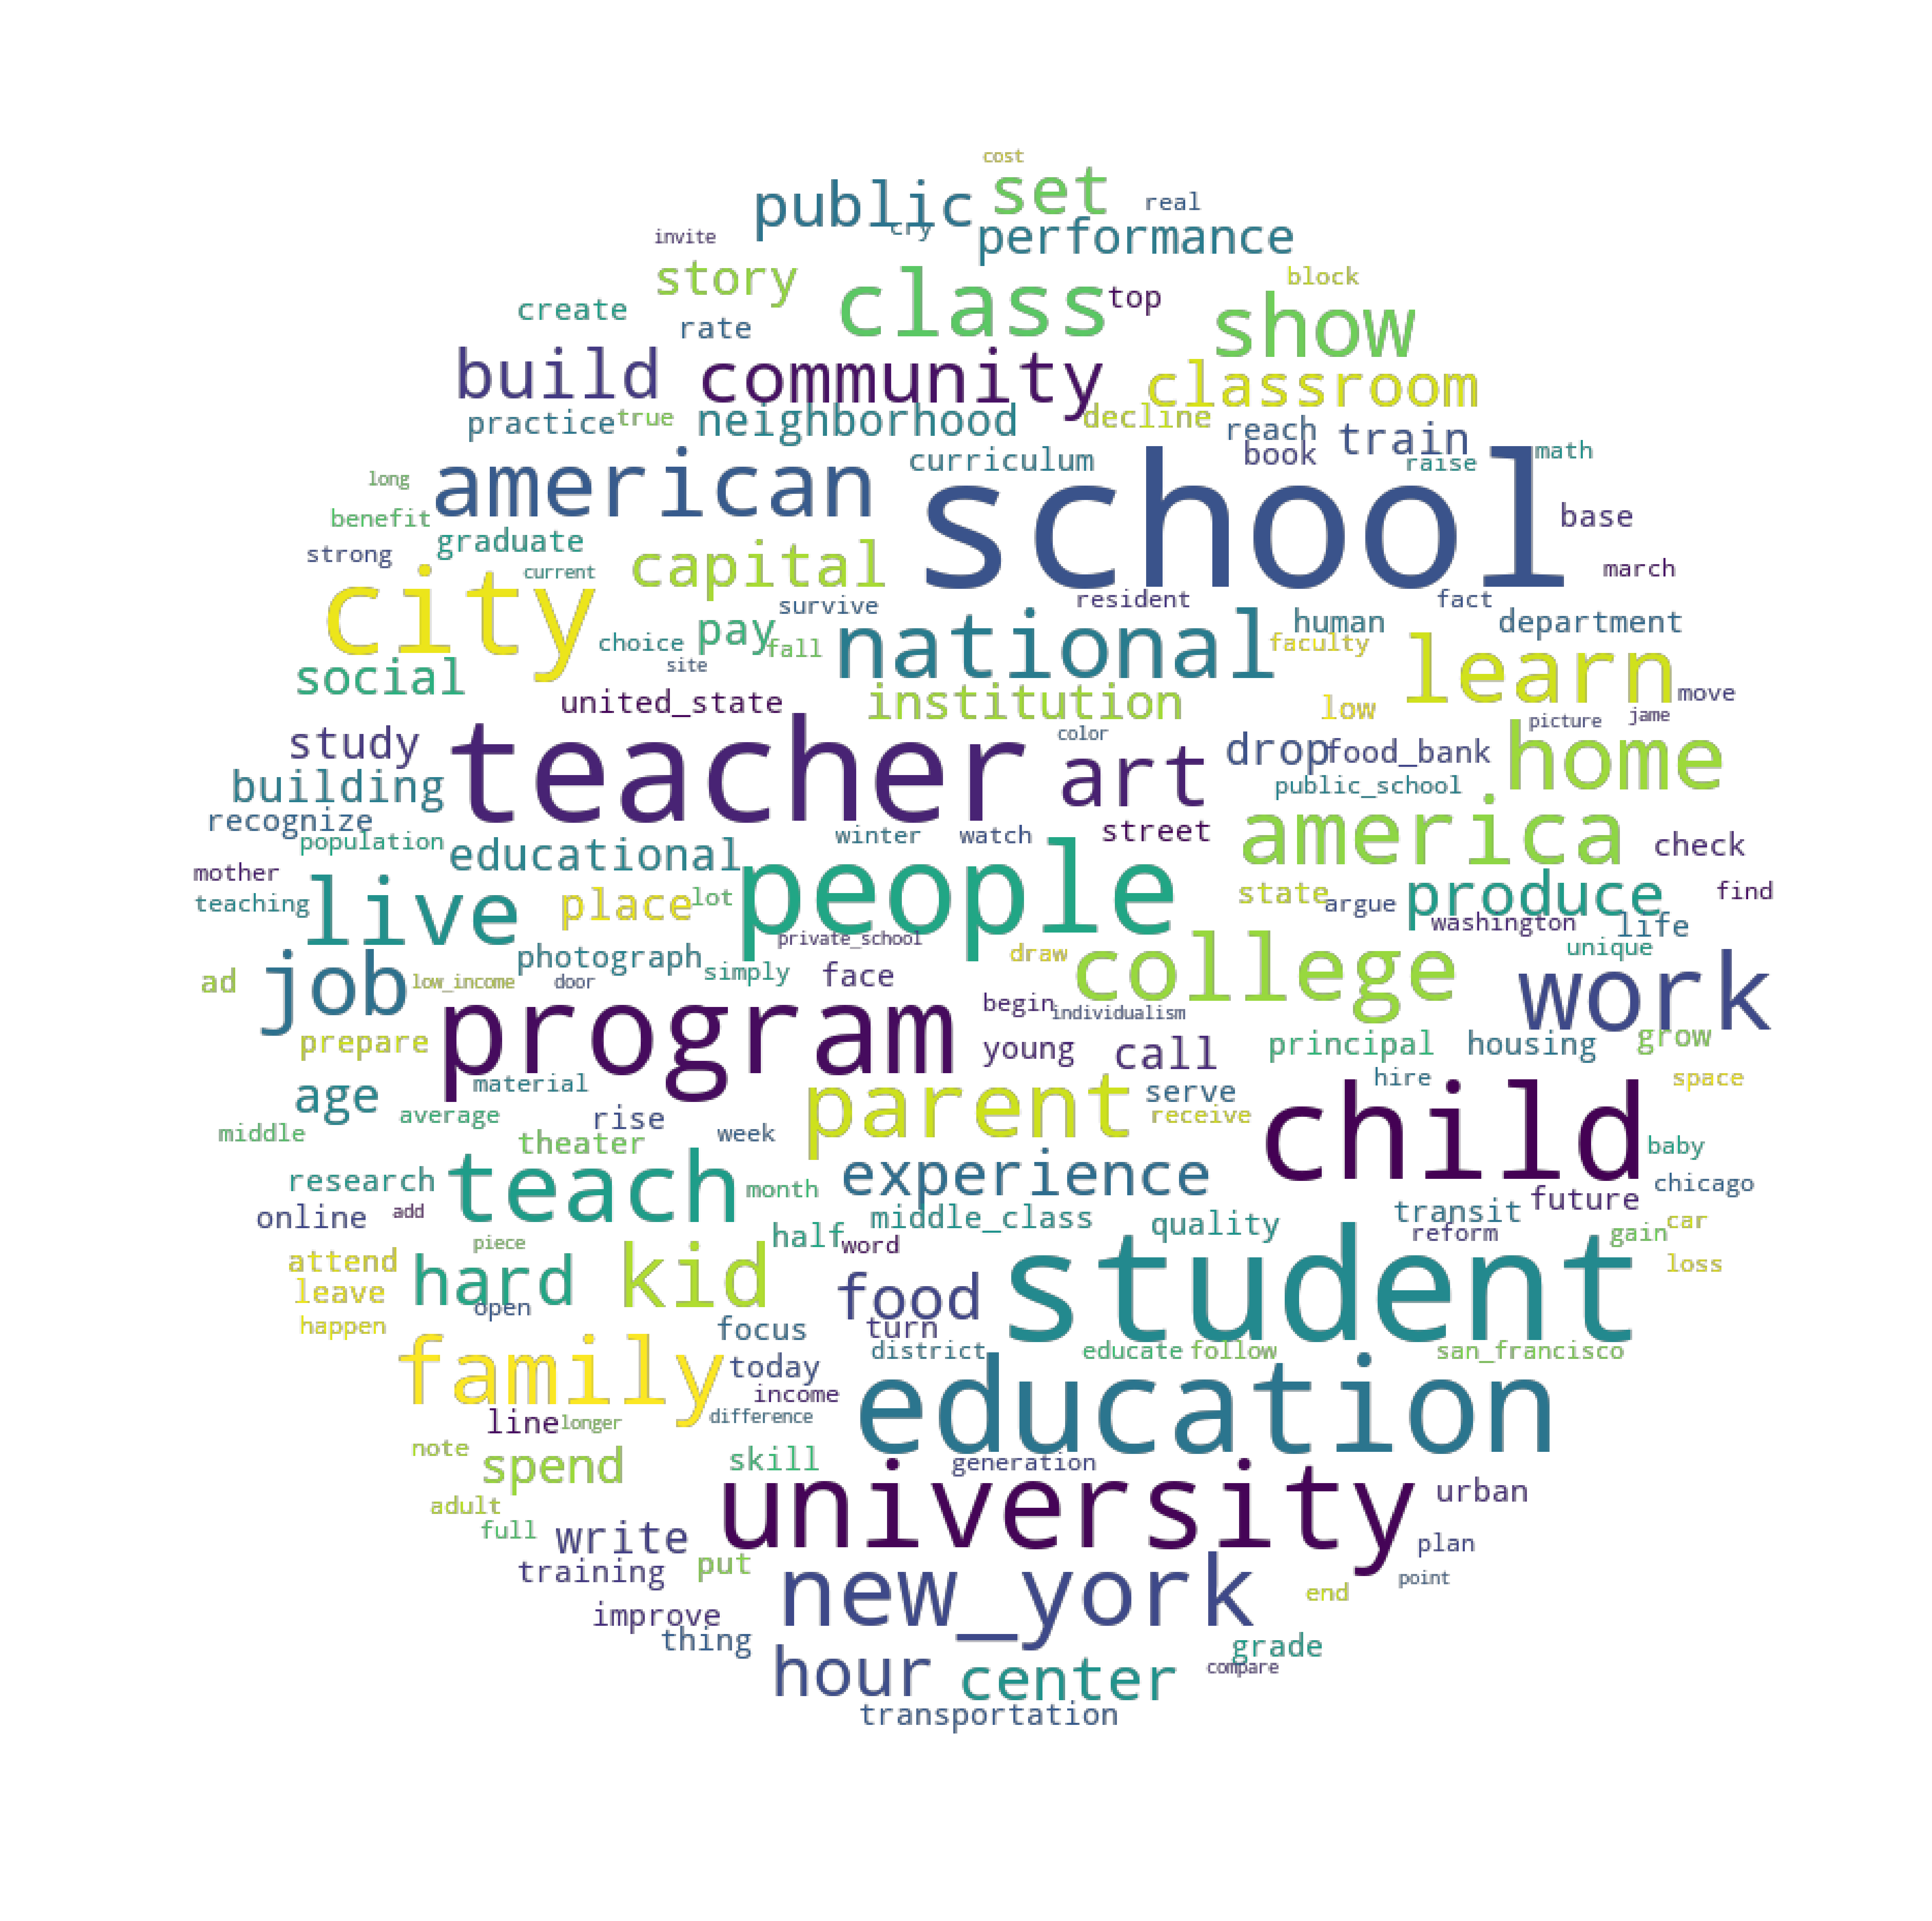

In [53]:
show_wordcloud(topic_words8)

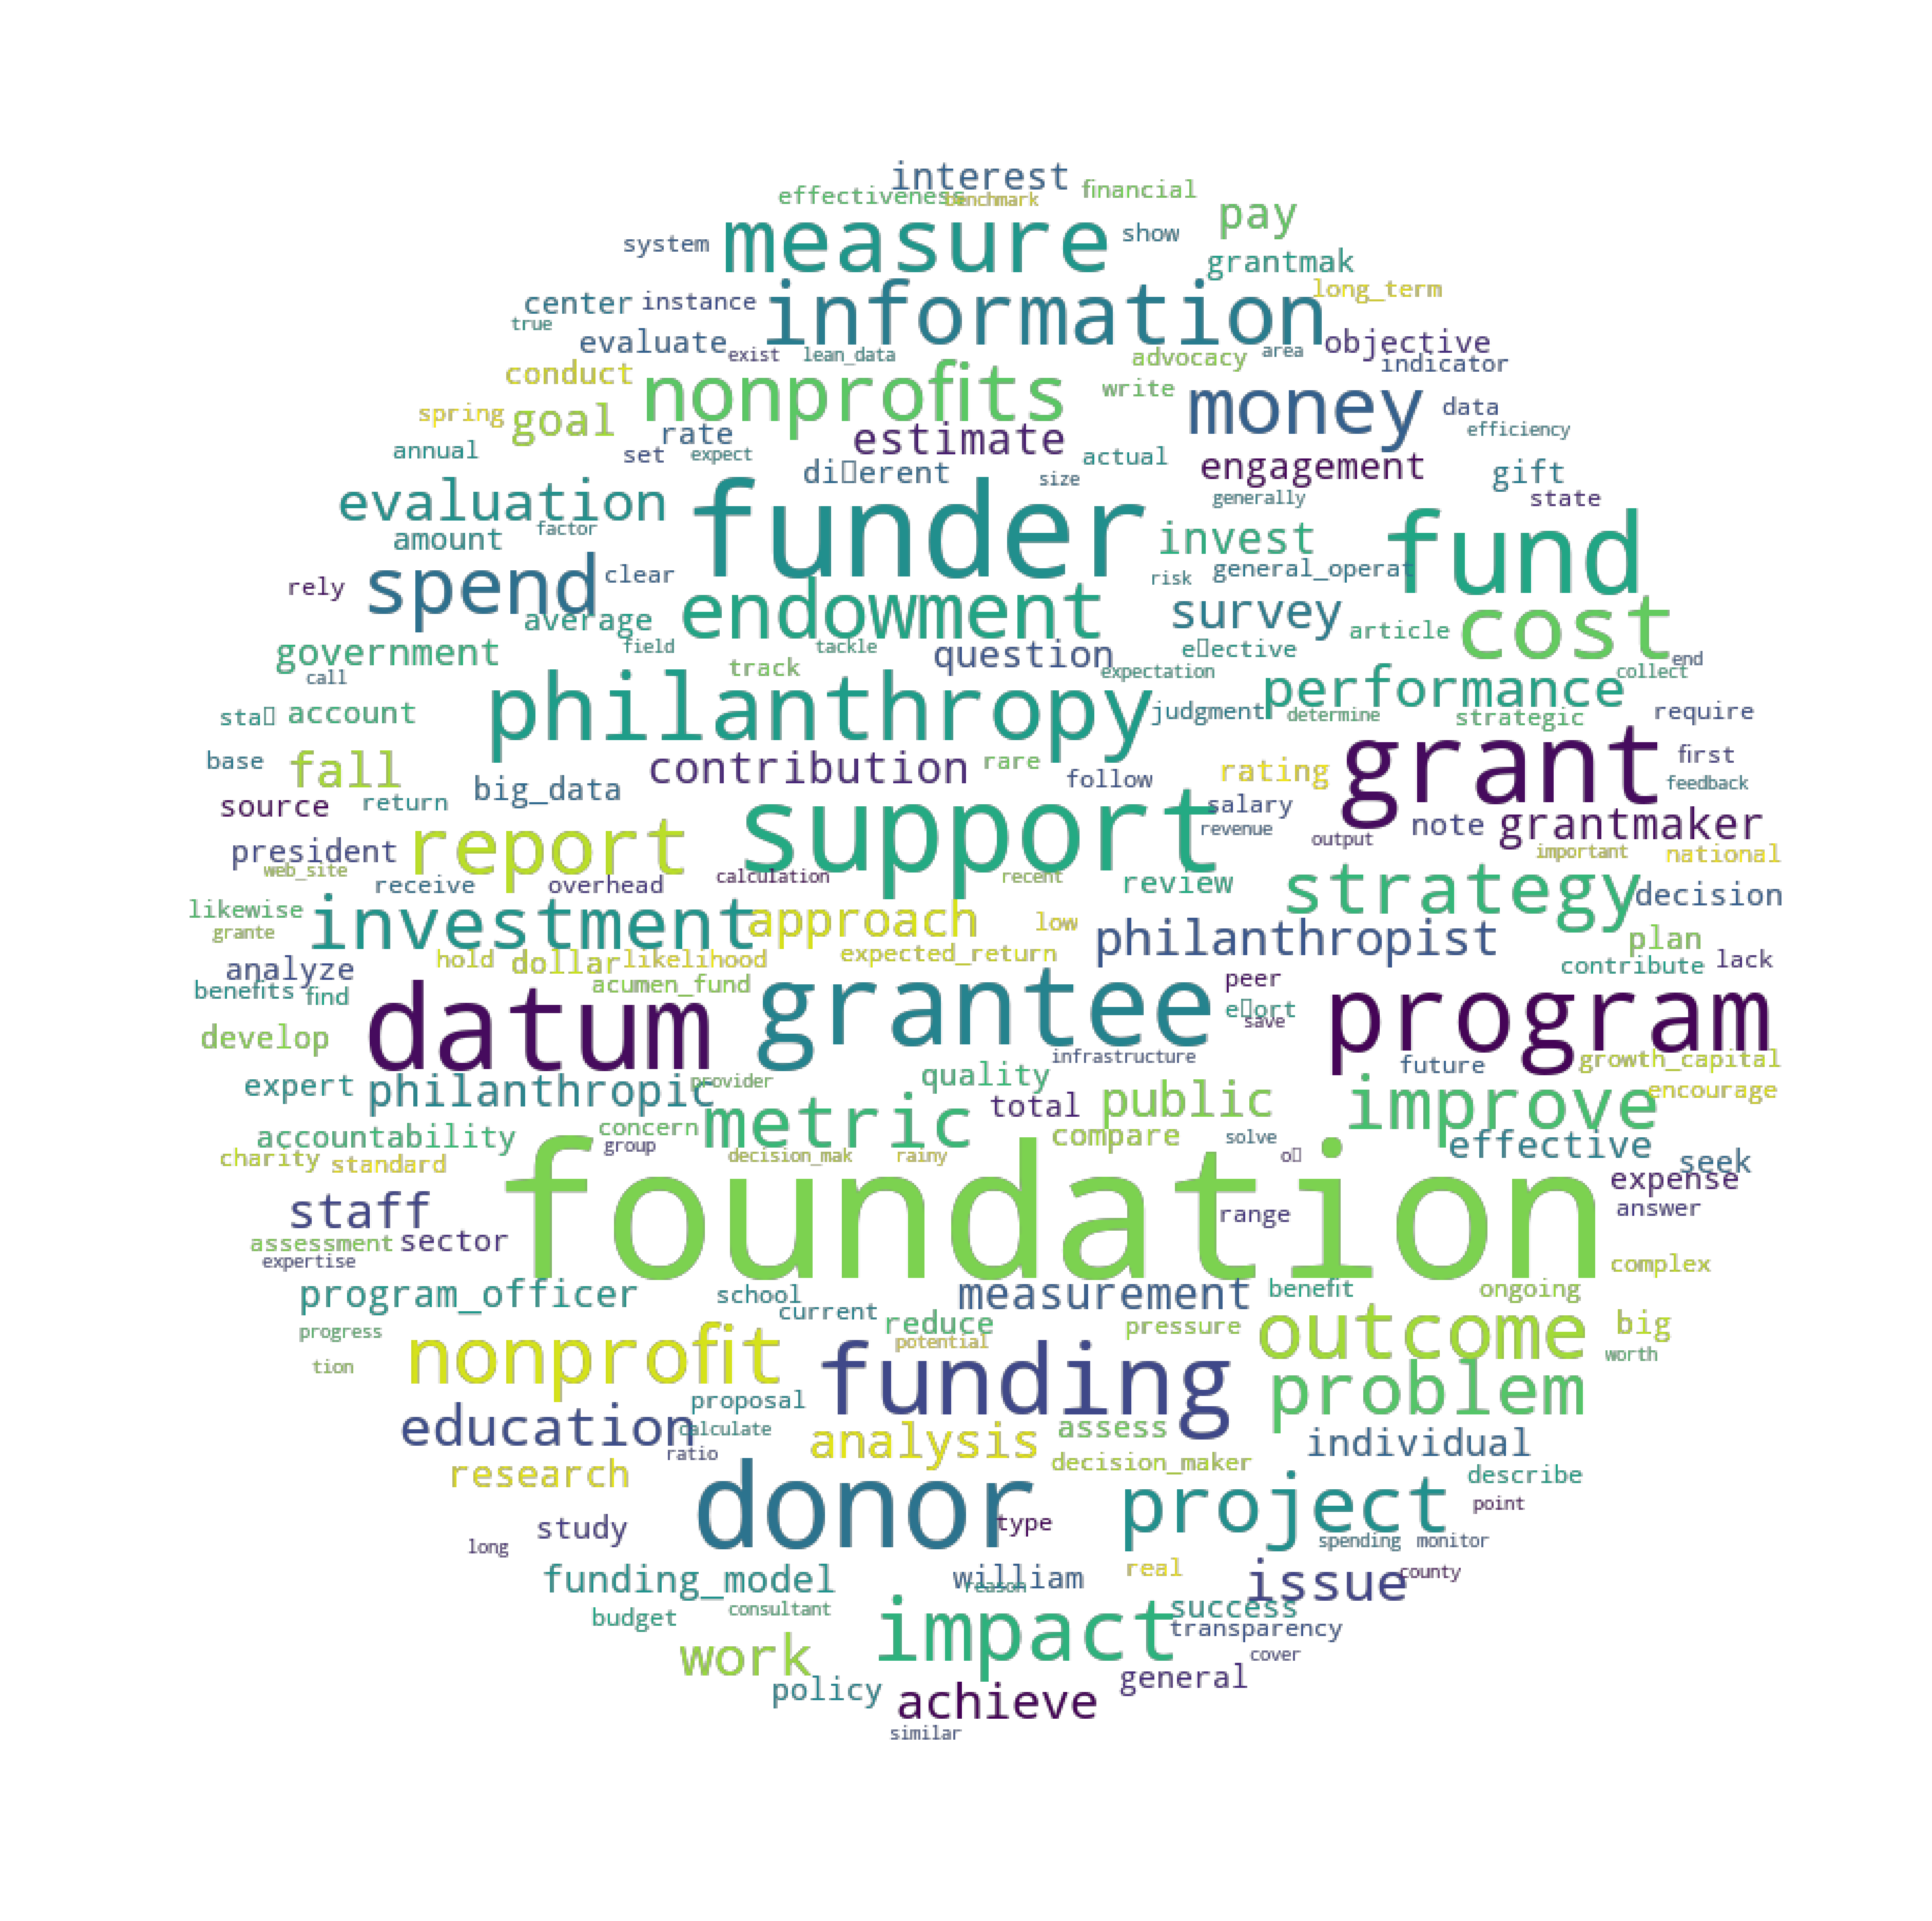

In [55]:
show_wordcloud(topic_words9)